# DeepRacer Log Analysis for Model Training
(Compatible with Logs from the AWS DeepRacer Console after Aug 2020)
<br>
___

This Notebook is a redo of Log Analysis solutions provided in the [AWS DeepRacer Workshops repository](https://github.com/aws-samples/aws-deepracer-workshops). The log analysis here parses log data from AWS RoboMaker (SIM_TRACE_LOG data) and Amazon SageMaker (policy training data), and introduces some analyses that are not present in the AWS samples.

With the new AWS DeepRacer console update in Aug 2020, these logs are no longer streamed to CloudWatch Logs during training. Instead, they are downloadable from the model page in the AWS DeepRacer console, after training has terminated.

The code here:
- is compatible with downloaded logs from the new console (after Aug 2020).
- should be backwards compatible with DeepRacer logs previously downloaded from CloudWatch Logs too.
- is maintained such that it can be run directly from a Amazon SageMaker Notebook instance, as long as the relative paths of the RoboMaker and SageMaker log files are specified correctly.
- does not require access to any AWS Services (hence no awscli or boto required) when analysing the log data files

In [1]:
#!docker logs --tail all $(docker ps | awk ' /sagemaker/ { print $1 }') > /home/ubuntu/deepracer/github/deepracer-log-analysis/logs/local-sagemaker_50.log 2>&1
#!docker logs --tail all $(docker ps | awk ' /robomaker/ { print $1 }') > /home/ubuntu/deepracer/github/deepracer-log-analysis/logs/local-robomaker_50.log 2>&1


In [2]:
# Check Python version
from platform import python_version
print(python_version())

3.6.10


# Import Required Packages

In [3]:
# Install pip packages in the current Jupyter kernel - for packages that are not installed by default
import sys
!{sys.executable} -m pip install shapely

# Add other packages here if import for them fails in the cell below, eg.:
#!{sys.executable} -m pip install numpy pandas matplotlib sklearn shapely boto3

Looking in indexes: http://ftp.daumkakao.com/pypi/simple


In [4]:
import math
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, AutoMinorLocator, MultipleLocator
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler

# Shapely Library
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LineString

from os import listdir
from os.path import isfile, join
import os.path

pd.set_option('display.max_rows', 500, 'display.max_columns', None)

# Specify the RoboMaker & SageMaker Log File Locations

In [5]:
# SPECIFY THE RELATIVE PATH/FILENAMES HERE ACCORDINGLY:
# - robomaker_fname: location of the AWS RoboMaker log file
# - sagemaker_fname: location of the Amazon SageMaker log file
robomaker_fname = 'logs/local-robomaker_50.log'
sagemaker_fname = 'logs/local-sagemaker_50.log'

robomaker_fname = 'logs/local-202011301951-robomaker.log'
sagemaker_fname = 'logs/local-202011301951-sagemaker.log'

# Retrieve Training Parameters, Hyperparameters & Action Space from Logs

In [6]:
def parse_robomaker_logs_training_parameters(robomaker_fname, training_parameter_name):
    os_cmd = "cat %s | grep -E '^[{].*[}]$' | grep 'WORLD[_]NAME' | grep 'AWS[_]REGION' | sed \"s/[']/\"'\"/g' | head -1" % (robomaker_fname)
    os_output = !$os_cmd
    training_parameters = json.loads(os_output[0])
    return training_parameters[training_parameter_name]

In [7]:
# Retrieve Training Parameters
'''
try:
    # Works with RoboMaker logs from Aug 2020 onwards
    AWS_REGION = parse_robomaker_logs_training_parameters(robomaker_fname, 'AWS_REGION')
    WORLD_NAME = parse_robomaker_logs_training_parameters(robomaker_fname, 'WORLD_NAME')
    SIMTRACE_S3_PREFIX = parse_robomaker_logs_training_parameters(robomaker_fname, 'SIMTRACE_S3_PREFIX')

    os_cmd = "echo '%s' | sed -e 's/^.*[/]models[/]//g' | cut -d'/' -f1" % (SIMTRACE_S3_PREFIX)
    MODEL_NAME = !$os_cmd
    MODEL_NAME = MODEL_NAME[0]

except:
    # Works with older RoboMaker logs
    os_cmd = "cat %s | grep -E '[*][ ][/]AWS[_]REGION[:]' | head -1" % (robomaker_fname)
    AWS_REGION = !$os_cmd
    AWS_REGION = AWS_REGION[0].split(':')[-1].split(' ')[-1]

    os_cmd = "cat %s | grep -E 'gzserver.*[/]worlds[/].*[.]world' | head -1" % (robomaker_fname)
    WORLD_NAME = !$os_cmd
    WORLD_NAME = WORLD_NAME[0].split('/worlds/')[-1].split('.world')[0]

    os_cmd = "cat %s | grep -E 'Successfully[ ]downloaded[ ]model[ ]metadata.*[/]model[_]metadata[.]json' | head -1" % (robomaker_fname)
    MODEL_NAME = !$os_cmd
    MODEL_NAME = MODEL_NAME[0].split('/model_metadata.json')[0].split('/')[-1]
'''
    

AWS_REGION='US-EAST'
WORLD_NAME='Austin'
MODEL_NAME='LA01-234'

print ('AWS_REGION: %s' % AWS_REGION)
print ('WORLD_NAME: %s' % WORLD_NAME)
print ('MODEL_NAME: %s' % MODEL_NAME)    


AWS_REGION: US-EAST
WORLD_NAME: Austin
MODEL_NAME: LA01-234


In [8]:
def parse_robomaker_logs_hyperparameters(robomaker_fname, hyperparameter_name):
    hyperparameter_name = hyperparameter_name.replace('_', '[_]')
    os_cmd = "cat %s | grep -E '^[ ]+[\"]%s[\"][:]' | cut -d':' -f2 | cut -d',' -f1 | sed -e 's/^[ ]*//g'" % (robomaker_fname, hyperparameter_name)
    os_output = !$os_cmd
    return os_output[0]

In [9]:
# Retrieve Hyperparameters

EPISODES_PER_ITERATION = int(parse_robomaker_logs_hyperparameters(robomaker_fname, 'num_episodes_between_training'))
NUM_EPOCHS = int(parse_robomaker_logs_hyperparameters(robomaker_fname, 'num_epochs'))

print ('EPISODES_PER_ITERATION: %s' % EPISODES_PER_ITERATION)
print ('NUM_EPOCHS: %s' % NUM_EPOCHS)

EPISODES_PER_ITERATION: 40
NUM_EPOCHS: 10


In [10]:
# Retrieve Action Space

action_space = !grep '^Reward Distribution Graph.*racecar' $robomaker_fname
action_space = action_space[0].replace('Reward Distribution Graph:', '')
action_space = action_space.replace('racecar', '')
action_space = action_space.replace("'", '"')
action_space = json.loads(action_space)
#action_space = [{'speed': 1.5, 'index': 0, 'steering_angle': -30}, {'speed': 1.9704, 'index': 1, 'steering_angle': -12.7506}, {'speed': 2.8773, 'index': 2, 'steering_angle': -7.0501}, {'speed': 1.7831, 'index': 3, 'steering_angle': -0.6292}, {'speed': 3.9238, 'index': 4, 'steering_angle': -0.0239}, {'speed': 3.3736, 'index': 5, 'steering_angle': 0.875}, {'speed': 2.3195, 'index': 6, 'steering_angle': 6.1889}, {'speed': 2.8651, 'index': 7, 'steering_angle': 7.3838}, {'speed': 1.785, 'index': 8, 'steering_angle': 13.6619}, {'speed': 1.5, 'index': 9, 'steering_angle': 30}]
action_space

[{'steering_angle': -30.0, 'speed': 1.2, 'index': 0},
 {'steering_angle': -23.0, 'speed': 1.4, 'index': 1},
 {'steering_angle': -18.9, 'speed': 1.6, 'index': 2},
 {'steering_angle': -12.1, 'speed': 2.5, 'index': 3},
 {'steering_angle': -8.0, 'speed': 3.5, 'index': 4},
 {'steering_angle': -6.0, 'speed': 5.0, 'index': 5},
 {'steering_angle': -3.4, 'speed': 5.0, 'index': 6},
 {'steering_angle': -2.7, 'speed': 2.5, 'index': 7},
 {'steering_angle': -0.5, 'speed': 4.9, 'index': 8},
 {'steering_angle': -0.3, 'speed': 7.0, 'index': 9},
 {'steering_angle': 0, 'speed': 8.0, 'index': 10},
 {'steering_angle': 0.9, 'speed': 7.0, 'index': 11},
 {'steering_angle': 3.6, 'speed': 2.6, 'index': 12},
 {'steering_angle': 6.4, 'speed': 4.0, 'index': 13},
 {'steering_angle': 7.7, 'speed': 3.5, 'index': 14},
 {'steering_angle': 8.5, 'speed': 1.5, 'index': 15},
 {'steering_angle': 12.0, 'speed': 3.7, 'index': 16},
 {'steering_angle': 15.2, 'speed': 2.4, 'index': 17},
 {'steering_angle': 19.0, 'speed': 1.5, 'i

In [11]:
action_names = []
for action in action_space:
    action_steering = ('%+.1f' % action['steering_angle']).replace('+0.0', 'CENTER:0.0').replace('+','LEFT:').replace('-','RIGHT:')
    action_speed = ('SPD:%.2f' % action['speed'])
    action_names.append(action_steering + ' / ' + action_speed)
action_names

['RIGHT:30.0 / SPD:1.20',
 'RIGHT:23.0 / SPD:1.40',
 'RIGHT:18.9 / SPD:1.60',
 'RIGHT:12.1 / SPD:2.50',
 'RIGHT:8.0 / SPD:3.50',
 'RIGHT:6.0 / SPD:5.00',
 'RIGHT:3.4 / SPD:5.00',
 'RIGHT:2.7 / SPD:2.50',
 'RIGHT:0.5 / SPD:4.90',
 'RIGHT:0.3 / SPD:7.00',
 'CENTER:0.0 / SPD:8.00',
 'LEFT:0.9 / SPD:7.00',
 'LEFT:3.6 / SPD:2.60',
 'LEFT:6.4 / SPD:4.00',
 'LEFT:7.7 / SPD:3.50',
 'LEFT:8.5 / SPD:1.50',
 'LEFT:12.0 / SPD:3.70',
 'LEFT:15.2 / SPD:2.40',
 'LEFT:19.0 / SPD:1.50',
 'LEFT:23.0 / SPD:1.40',
 'LEFT:30.0 / SPD:1.20']

In [12]:
action_speed = list()
action_steering = list()

for action in action_space:
    action_speed.append(action['speed'])
    action_steering.append(action['steering_angle'])

print ('SPEED: %s' % action_speed)
print ('STEERING: %s' % action_steering)

action_min_speed = min(action_speed)
action_max_speed = max(action_speed)
action_min_steering = min(action_steering)
action_max_steering = max(action_steering)

print ('MIN SPEED: %f' % action_min_speed)
print ('MAX SPEED: %f' % action_max_speed)
print ('MIN STEERING: %f' % action_min_steering)
print ('MAX STEERING: %f' % action_max_steering)

action_speed_range = action_max_speed - action_min_speed
action_steering_range = action_max_steering - action_min_steering

print ('SPEED RANGE: %f' % action_speed_range)
print ('STEERING RANGE: %f' % action_steering_range)


SPEED: [1.2, 1.4, 1.6, 2.5, 3.5, 5.0, 5.0, 2.5, 4.9, 7.0, 8.0, 7.0, 2.6, 4.0, 3.5, 1.5, 3.7, 2.4, 1.5, 1.4, 1.2]
STEERING: [-30.0, -23.0, -18.9, -12.1, -8.0, -6.0, -3.4, -2.7, -0.5, -0.3, 0, 0.9, 3.6, 6.4, 7.7, 8.5, 12.0, 15.2, 19.0, 23.0, 30.0]
MIN SPEED: 1.200000
MAX SPEED: 8.000000
MIN STEERING: -30.000000
MAX STEERING: 30.000000
SPEED RANGE: 6.800000
STEERING RANGE: 60.000000


# Parse *Simulation* Job (AWS RoboMaker) Logs

In [13]:
# Check that the RoboMaker Log file exists

print('RoboMaker Log file size: %d' % os.stat(robomaker_fname).st_size)
!tail $robomaker_fname

RoboMaker Log file size: 158135427
SIM_TRACE_LOG:8046,71,6.6829,1.8641,162.7131,0.90,7.00,11,0.0010,False,True,17.1439,100,59.35,1606733505.358031,in_progress

SIM_TRACE_LOG:8046,72,6.5115,1.9168,162.8347,0.00,8.00,10,3.7696,False,True,17.4461,101,59.35,1606733505.4391685,in_progress

SIM_TRACE_LOG:8046,73,6.2297,2.0016,163.0183,0.00,8.00,10,3.7614,False,True,17.9418,102,59.35,1606733505.5194137,in_progress

SIM_TRACE_LOG:8046,74,5.9512,2.0858,163.0177,0.00,8.00,10,3.7558,False,True,18.4319,103,59.35,1606733505.6137638,in_progress

SIM_TRACE_LOG:8046,75,5.6491,2.1749,163.2514,0.00,8.00,10,3.7469,False,True,18.9626,104,59.35,1606733505.6491373,in_progress



In [14]:
# Retrieve SIM_TRACE_LOGs from the RoboMaker Log file

sim_data = []
with open(robomaker_fname, 'r') as f:
    for line in f.readlines():
        if "SIM_TRACE_LOG" in line:
            parts = line.split("SIM_TRACE_LOG:")[1].split('\t')[0].split('\n')[0].split(",")
            sim_data.append(",".join(parts))
sim_data[-20:]

['8046,56,8.8313,1.1398,138.8722,-2.70,2.50,7,3.7662,False,True,13.2871,93,59.35,1606733504.3643248,in_progress',
 '8046,57,8.7430,1.1993,141.7261,8.50,1.50,15,0.0010,False,True,13.4648,93,59.35,1606733504.4240394,in_progress',
 '8046,58,8.6039,1.2750,147.2535,-8.00,3.50,4,2.6822,False,True,13.7312,94,59.35,1606733504.4910102,in_progress',
 '8046,59,8.4836,1.3331,150.8572,-12.10,2.50,3,0.0010,False,True,13.9715,94,59.35,1606733504.5641005,in_progress',
 '8046,60,8.3565,1.3940,152.6264,12.00,3.70,16,3.2155,False,True,14.2080,95,59.35,1606733504.635244,in_progress',
 '8046,61,8.2262,1.4548,153.8649,8.50,1.50,15,0.0010,False,True,14.4569,95,59.35,1606733504.693861,in_progress',
 '8046,62,8.1002,1.5050,155.9893,8.50,1.50,15,0.0010,False,True,14.6848,96,59.35,1606733504.7588727,in_progress',
 '8046,63,7.9140,1.5665,159.6692,8.50,1.50,15,0.0010,False,True,15.0149,96,59.35,1606733504.8315308,in_progress',
 '8046,64,7.7904,1.6009,161.8823,0.90,7.00,11,1.9787,False,True,15.2307,97,59.35,1606733

In [15]:
# Parse the SIM_TRACE_LOG data

df_list = list()

# Ignore the first two dummy values that coach throws at the start
# (not sure if it's still necessary to do so?)
for d in sim_data[2:]:
    parts = d.rstrip().split(",")
    episode = int(parts[0])
    steps = int(parts[1])
    x = 100*float(parts[2])
    y = 100*float(parts[3])
    ##cWp = get_closest_waypoint(x, y, wpts)
    yaw = float(parts[4])
    steer = float(parts[5])
    throttle = float(parts[6])
    action = float(parts[7])
    reward = float(parts[8])
    done = 0 if 'False' in parts[9] else 1
    all_wheels_on_track = parts[10]
    progress = float(parts[11])
    closest_waypoint = int(parts[12])
    track_len = float(parts[13])
    tstamp = float(parts[14])
    status = parts[15]

    #iteration = int(episode / EPISODES_PER_ITERATION) + 1
    iteration = int(episode / EPISODES_PER_ITERATION) # remove 1
    if (iteration == 0) and (episode == 0):
        steps -= 2
    episode_in_iteration = (episode % EPISODES_PER_ITERATION) + 1
    episode += 1
    df_list.append((iteration, episode_in_iteration, episode, steps, x, y, yaw, steer, throttle, action, reward, done, all_wheels_on_track, progress,
                    closest_waypoint, track_len, tstamp, status))

header = ['iteration', 'episode_in_iteration', 'episode', 'steps', 'x', 'y', 'yaw', 'steer', 'throttle', 'action', 'reward', 'done', 'on_track', 'progress', 'closest_waypoint', 'track_len', 'timestamp', 'status']
sim_df = pd.DataFrame(df_list, columns=header)
sim_df

iteration  episode_in_iteration  episode  steps       x       y  \
0                0                     1        1      1 -865.15 -149.91   
1                0                     1        1      2 -863.80 -152.24   
2                0                     1        1      3 -861.40 -156.27   
3                0                     1        1      4 -857.89 -161.84   
4                0                     1        1      5 -853.53 -169.56   
...            ...                   ...      ...    ...     ...     ...   
1224066        201                     7     8047     71  668.29  186.41   
1224067        201                     7     8047     72  651.15  191.68   
1224068        201                     7     8047     73  622.97  200.16   
1224069        201                     7     8047     74  595.12  208.58   
1224070        201                     7     8047     75  564.91  217.49   

              yaw  steer  throttle  action  reward  done on_track  progress  \
0        -62.4672    0.0       8.0    10.0  1.9967     0     True    0.2560   
1        -62.2581   -0.3       7.0     9.0  1.9990     0     True    0.3012   
2        -61.6304   -6.0       5.0     5.0  3.2204     0     True    0.3801   
3        -60.6003    6.4       4.0    13.0  0.0010     0     True    0.4907   
4        -60.6201    0.0       8.0    10.0  1.9828     0     True    0.6400   
...           ...    ...       ...     ...     ...   ...      ...       ...   
1224066  162.7131    0.9       7.0    11.0  0.0010     0     True   17.1439   
1224067  162.8347    0.0       8.0    10.0  3.7696     0     True   17.4461   
1224068  163.0183    0.0       8.0    10.0  3.7614     0     True   17.9418   
1224069  163.0177    0.0       8.0    10.0  3.7558     0     True   18.4319   
1224070  163.2514    0.0       8.0    10.0  3.7469     0     True   18.9626   

         closest_waypoint  track_len     timestamp       status  
0                       1      59.35  1.606628e+09  in_progress  
1                       1      59.35  1.606628e+09  in_progress  
2                       1      59.35  1.606628e+09  in_progress  
3                       1      59.35  1.606628e+09  in_progress  
4                       1      59.35  1.606628e+09  in_progress  
...                   ...        ...           ...          ...  
1224066               100      59.35  1.606734e+09  in_progress  
1224067               101      59.35  1.606734e+09  in_progress  
1224068               102      59.35  1.606734e+09  in_progress  
1224069               103      59.35  1.606734e+09  in_progress  
1224070               104      59.35  1.606734e+09  in_progress  

[1224071 rows x 18 columns]

In [16]:
# Calculate episode-related data

sim_df_episodes = sim_df[sim_df["done"] == 1][["iteration", "episode_in_iteration", "episode", "steps", "progress", "status"]].copy()
sim_df_episodes["episode_total_rewards"] = sim_df.groupby("episode")["reward"].transform("sum")
sim_df_episodes["elapsed_time"] = sim_df.groupby("episode")["timestamp"].transform("max") - sim_df.groupby("episode")["timestamp"].transform("min")
sim_df_episodes["start_time"] = sim_df.groupby("episode")["timestamp"].transform("min")
sim_df_episodes["end_time"] = sim_df.groupby("episode")["timestamp"].transform("max")

sim_df_episodes[sim_df_episodes['episode_in_iteration']==1]

iteration  episode_in_iteration  episode  steps  progress  \
102              0                     1        1    103   22.9850   
2248             1                     1       41      1    0.2364   
4546             2                     1       81     84   16.1536   
6729             3                     1      121     30    7.1570   
8774             4                     1      161     45    9.3788   
11284            5                     1      201     44    8.9062   
13280            6                     1      241     60   11.9056   
15575            7                     1      281     47    9.6327   
17852            8                     1      321     29    5.9326   
20253            9                     1      361     35    7.8781   
22335           10                     1      401     35    7.3397   
24582           11                     1      441     60   11.9056   
27034           12                     1      481     58   11.9160   
29372           13                     1      521     62   13.1913   
32170           14                     1      561     60   11.6018   
34829           15                     1      601     60   11.3247   
37206           16                     1      641     59   12.8267   
39771           17                     1      681     36    6.8253   
42665           18                     1      721    102   26.3481   
45450           19                     1      761     60   15.2376   
48244           20                     1      801     59   12.5196   
50822           21                     1      841     58   11.1910   
53711           22                     1      881     56   12.2093   
56367           23                     1      921     77   17.9298   
58960           24                     1      961     56   11.7883   
61700           25                     1     1001     90   24.7669   
64789           26                     1     1041     47    9.5171   
68326           27                     1     1081     75   18.8837   
70950           28                     1     1121     54   11.5898   
73924           29                     1     1161    120   26.1329   
76869           30                     1     1201     57   11.6018   
79355           31                     1     1241      1    0.2362   
82352           32                     1     1281     54   11.9446   
85596           33                     1     1321     62   13.3202   
88535           34                     1     1361     59   11.3371   
91536           35                     1     1401     54   11.2309   
94735           36                     1     1441     62   11.9878   
98011           37                     1     1481     59   11.6018   
100881          38                     1     1521     76   16.0726   
104183          39                     1     1561    116   24.0268   
108177          40                     1     1601    243   60.8832   
111258          41                     1     1641     69   16.7913   
114277          42                     1     1681     80   19.3454   
117379          43                     1     1721     57   11.0169   
120477          44                     1     1761     64   16.8976   
123733          45                     1     1801     59   11.6957   
126848          46                     1     1841     42    8.1807   
130123          47                     1     1881     70   14.7793   
133586          48                     1     1921     47    9.0975   
137083          49                     1     1961     54   10.9639   
140039          50                     1     2001    121   31.2210   
143393          51                     1     2041    230   64.4967   
146640          52                     1     2081     68   15.2290   
150144          53                     1     2121     80   20.2923   
153687          54                     1     2161    122   40.1374   
157039          55                     1     2201      1    0.2360   
160930          56 

In [17]:
# Calculate iteration-related data

sim_df_iterations = sim_df_episodes[sim_df_episodes["episode_in_iteration"] == 1][["iteration"]].copy()
sim_df_iterations["min_progress"] = sim_df_episodes.groupby("iteration")["progress"].transform("min")
sim_df_iterations["max_progress"] = sim_df_episodes.groupby("iteration")["progress"].transform("max")
sim_df_iterations["avg_progress"] = sim_df_episodes.groupby("iteration")["progress"].transform("mean")
sim_df_iterations["total_rewards"] = sim_df.groupby("iteration")["reward"].transform("sum")
sim_df_iterations["start_time"] = sim_df_episodes.groupby("iteration")["start_time"].transform("min")
sim_df_iterations["end_time"] = sim_df_episodes.groupby("iteration")["end_time"].transform("max")

lap_count = sim_df_episodes[sim_df_episodes["progress"] >= 100.0].groupby("iteration")["progress"].count()
sim_df_iterations = pd.merge(sim_df_iterations,lap_count,on="iteration",how="outer")
sim_df_iterations.rename(columns={"progress":"completed_laps"}, inplace=True)
sim_df_iterations["completed_laps"].fillna(0, inplace=True)
sim_df_iterations["completed_laps"] = sim_df_iterations["completed_laps"].astype(int)

episode_count = sim_df_episodes.groupby("iteration")["episode_in_iteration"].count()
sim_df_iterations = pd.merge(sim_df_iterations,episode_count,on="iteration",how="outer")
sim_df_iterations.rename(columns={"episode_in_iteration":"episodes"}, inplace=True)
sim_df_iterations["pct_completed_laps"] = (sim_df_iterations["completed_laps"] / sim_df_iterations["episodes"] * 100.0)

if (sim_df_iterations.tail(1)['episodes'].values[0] < EPISODES_PER_ITERATION):
    sim_df_iterations.drop(sim_df_iterations.tail(1).index,inplace=True)
sim_df_iterations

iteration  min_progress  max_progress  avg_progress  total_rewards  \
0            0        2.1531       42.3344     12.826947      2467.8566   
1            1        0.2364       30.4083     12.172745      2304.8893   
2            2        2.0977       37.3166     11.971118      2320.2952   
3            3        2.7783       27.8079     11.160210      2414.3445   
4            4        2.3232       42.9048     14.436225      3136.9186   
5            5        0.2362       23.0154     10.539520      2238.9942   
6            6        2.2800       33.8807     12.457370      2664.2910   
7            7        3.1172       32.3439     12.381155      2753.9357   
8            8        4.9407       38.2949     13.830815      2981.5017   
9            9        2.5353       24.5685     11.229040      2541.0286   
10          10        0.2361       34.1895     12.665742      2816.4033   
11          11        0.2324       43.0611     13.991133      3225.2392   
12          12        3.0295       48.7796     13.622265      3212.4479   
13          13        3.0771       50.7127     16.268538      3315.1085   
14          14        4.0185       45.9013     15.035900      3411.5083   
15          15        0.2363       32.6828     13.521402      3055.6530   
16          16        5.2858       30.4075     14.563680      3359.0799   
17          17        3.4195       48.4641     16.958025      3695.6884   
18          18        3.1112       48.1848     17.040040      4026.0075   
19          19        0.2359       36.9920     16.529940      3535.5174   
20          20        2.7440       39.4838     15.203887      3384.0921   
21          21        4.7793       42.3489     16.596225      3864.6834   
22          22        3.6302       39.8819     14.688342      3347.8399   
23          23        2.1570       33.6772     14.634783      3073.2538   
24          24        5.0624       43.3367     15.170800      3770.4520   
25          25        5.6954       42.8117     18.633390      3962.3608   
26          26        4.9024       86.8316     21.705250      4894.2630   
27          27        4.4526       47.4582     15.864835      3735.4270   
28          28        2.1030       42.1157     16.409712      3786.5378   
29          29        4.2195       50.8420     17.043320      3849.2709   
30          30        0.2322       33.0841     14.841500      3553.3370   
31          31        0.2360       41.0342     16.946495      3729.1389   
32          32        4.9407       51.2783     18.364477      4267.5270   
33          33        0.2360       56.2150     17.852348      3912.3477   
34          34        5.9863       43.7235     17.425610      4014.1286   
35          35        4.1398       40.1101     18.173885      4302.5171   
36          36        3.1112       44.1384     18.608555      4439.8912   
37          37        0.2362       36.7380     16.256998      3616.3197   
38          38      -24.0263       67.9561     17.930990      4566.6790   
39          39        4.6541       70.3669     21.971447      4864.0481   
40          40        6.7538       60.8832     19.085418      4291.5983   
41          41        4.2232       59.6799     18.028173      4172.1863   
42          42        0.2321       42.4530     18.147948      3963.0242   
43          43        5.3966       49.4125     17.654958      4102.9995   
44          44        0.2363       51.7542     19.884190      4404.7944   
45          45        0.2362       41.9056     17.657435      4305.5438   
46          46        1.5307       54.9629     19.637665      4384.3598   
47          47        4.5196       61.4058     20.180480      4655.4540   
48          48        0.2364       86.1650     21.438715      4650.1201   
49          49        4.4393       39.8334     16.928402      3741.2947   
50          50        4.7793       58.1836     19.408355      4508.5274   
51          51        2.6022       65.9206     20.492625      4550.0925   
52          52        0.2357  

In [18]:
# Calculate aggregated values for iterations

x = sim_df_iterations[['total_rewards']].values.astype(float)
if (len(x)>0):
    min_max_scaler = MinMaxScaler(feature_range=(5,95))
    x_scaled = min_max_scaler.fit_transform(x)
    sim_df_iterations['total_rewards_normalized'] = x_scaled
    sim_df_iterations

In [19]:
print ('%d' % len(sim_df_iterations))
if (len(sim_df_iterations) > 0):
    sim_df_iterations['total_rewards_normalized_SMA3'] = sim_df_iterations['total_rewards_normalized'].rolling(window=3).mean()
    sim_df_iterations['min_progress_SMA3'] = sim_df_iterations['min_progress'].rolling(window=3).mean()
    sim_df_iterations['max_progress_SMA3'] = sim_df_iterations['max_progress'].rolling(window=3).mean()
    sim_df_iterations['avg_progress_SMA3'] = sim_df_iterations['avg_progress'].rolling(window=3).mean()
    sim_df_iterations['pct_completed_laps_SMA3'] = sim_df_iterations['pct_completed_laps'].rolling(window=3).mean()

sim_df_iterations

201


iteration  min_progress  max_progress  avg_progress  total_rewards  \
0            0        2.1531       42.3344     12.826947      2467.8566   
1            1        0.2364       30.4083     12.172745      2304.8893   
2            2        2.0977       37.3166     11.971118      2320.2952   
3            3        2.7783       27.8079     11.160210      2414.3445   
4            4        2.3232       42.9048     14.436225      3136.9186   
5            5        0.2362       23.0154     10.539520      2238.9942   
6            6        2.2800       33.8807     12.457370      2664.2910   
7            7        3.1172       32.3439     12.381155      2753.9357   
8            8        4.9407       38.2949     13.830815      2981.5017   
9            9        2.5353       24.5685     11.229040      2541.0286   
10          10        0.2361       34.1895     12.665742      2816.4033   
11          11        0.2324       43.0611     13.991133      3225.2392   
12          12        3.0295       48.7796     13.622265      3212.4479   
13          13        3.0771       50.7127     16.268538      3315.1085   
14          14        4.0185       45.9013     15.035900      3411.5083   
15          15        0.2363       32.6828     13.521402      3055.6530   
16          16        5.2858       30.4075     14.563680      3359.0799   
17          17        3.4195       48.4641     16.958025      3695.6884   
18          18        3.1112       48.1848     17.040040      4026.0075   
19          19        0.2359       36.9920     16.529940      3535.5174   
20          20        2.7440       39.4838     15.203887      3384.0921   
21          21        4.7793       42.3489     16.596225      3864.6834   
22          22        3.6302       39.8819     14.688342      3347.8399   
23          23        2.1570       33.6772     14.634783      3073.2538   
24          24        5.0624       43.3367     15.170800      3770.4520   
25          25        5.6954       42.8117     18.633390      3962.3608   
26          26        4.9024       86.8316     21.705250      4894.2630   
27          27        4.4526       47.4582     15.864835      3735.4270   
28          28        2.1030       42.1157     16.409712      3786.5378   
29          29        4.2195       50.8420     17.043320      3849.2709   
30          30        0.2322       33.0841     14.841500      3553.3370   
31          31        0.2360       41.0342     16.946495      3729.1389   
32          32        4.9407       51.2783     18.364477      4267.5270   
33          33        0.2360       56.2150     17.852348      3912.3477   
34          34        5.9863       43.7235     17.425610      4014.1286   
35          35        4.1398       40.1101     18.173885      4302.5171   
36          36        3.1112       44.1384     18.608555      4439.8912   
37          37        0.2362       36.7380     16.256998      3616.3197   
38          38      -24.0263       67.9561     17.930990      4566.6790   
39          39        4.6541       70.3669     21.971447      4864.0481   
40          40        6.7538       60.8832     19.085418      4291.5983   
41          41        4.2232       59.6799     18.028173      4172.1863   
42          42        0.2321       42.4530     18.147948      3963.0242   
43          43        5.3966       49.4125     17.654958      4102.9995   
44          44        0.2363       51.7542     19.884190      4404.7944   
45          45        0.2362       41.9056     17.657435      4305.5438   
46          46        1.5307       54.9629     19.637665      4384.3598   
47          47        4.5196       61.4058     20.180480      4655.4540   
48          48        0.2364       86.1650     21.438715      4650.1201   
49          49        4.4393       39.8334     16.928402      3741.2947   
50          50        4.7793       58.1836     19.408355      4508.5274   
51          51        2.6022       65.9206     20.492625      4550.0925   
52          52        0.2357  

# Parse *Training* Job (Amazon SageMaker) Logs

In [20]:
# Check that the SageMaker Log file exists

print('SageMaker Log file size: %d' % os.stat(sagemaker_fname).st_size)
!tail $sagemaker_fname

SageMaker Log file size: 1314635












In [21]:
# Retrieve policy training data from the SageMaker Log file

trn_data = []
last_iteration_id = 0
with open(sagemaker_fname, 'r') as f:
    for line in f.readlines():
        if "Training> Name=main_level/agent, " in line:
            parts = line.split("Training> Name=main_level/agent, ")[1].split('\t')[0].split('\n')[0].split(',')
            last_iteration_id = [parts[-1].split('=')[1]]
        if "Policy training> " in line:
            parts = line.split("Policy training> ")[1].split('\t')[0].split('\n')[0].split(',')
            parts = [x.split('=')[1] for x in parts]
            trn_data.append(",".join(last_iteration_id + parts))
trn_data[1:20]

['0,-0.03520630672574043,0.003297738963738084,1.8998278379440308,1,1e-05',
 '0,-0.055713821202516556,0.004959743469953537,1.8964871168136597,2,1e-05',
 '0,-0.06350234895944595,0.00509999506175518,1.9046659469604492,3,1e-05',
 '0,-0.073904849588871,0.0055186995305120945,1.9073338508605957,4,1e-05',
 '0,-0.08767642080783844,0.006300713401287794,1.908431053161621,5,1e-05',
 '0,-0.09357897937297821,0.006781090050935745,1.9115954637527466,6,1e-05',
 '0,-0.09529349207878113,0.00727331405505538,1.9117166996002197,7,1e-05',
 '0,-0.10458610951900482,0.00784392561763525,1.9062871932983398,8,1e-05',
 '0,-0.10337106138467789,0.008655976504087448,1.9057304859161377,9,1e-05',
 '1,-0.004893694072961807,0.0005100291455164552,1.874638557434082,0,1e-05',
 '1,-0.03917032480239868,0.003997087012976408,1.8459161520004272,1,1e-05',
 '1,-0.059509746730327606,0.006895632017403841,1.8304994106292725,2,1e-05',
 '1,-0.0710950419306755,0.006224919110536575,1.8425439596176147,3,1e-05',
 '1,-0.07304871827363968,0.0

In [22]:
# Parse the policy training data

df_list = list()

for d in trn_data:
    parts = d.rstrip().split(",")
    iteration = int(parts[0]) + 1 # add 1 so as to match model.pb (training iteration n == model.pb n+1)
    surrogate_loss = float(parts[1])
    kl_divergence = float(parts[2])
    entropy = float(parts[3])
    training_epoch = int(parts[4]) + 1
    learning_rate = float(parts[5])

    df_list.append((iteration, surrogate_loss, kl_divergence, entropy, training_epoch, learning_rate))

header = ['iteration', 'surrogate_loss', 'kl_divergence', 'entropy', 'training_epoch', 'learning_rate']
trn_df = pd.DataFrame(df_list, columns=header)
trn_df

iteration  surrogate_loss  kl_divergence   entropy  training_epoch  \
0             1        0.005071       0.000790  1.924028               1   
1             1       -0.035206       0.003298  1.899828               2   
2             1       -0.055714       0.004960  1.896487               3   
3             1       -0.063502       0.005100  1.904666               4   
4             1       -0.073905       0.005519  1.907334               5   
...         ...             ...            ...       ...             ...   
2005        201       -0.047540       0.035311  0.530786               6   
2006        201       -0.050452       0.036506  0.528292               7   
2007        201       -0.052558       0.037349  0.529207               8   
2008        201       -0.055135       0.039736  0.525866               9   
2009        201       -0.057281       0.040768  0.524072              10   

      learning_rate  
0           0.00001  
1           0.00001  
2           0.00001  
3           0.00001  
4           0.00001  
...             ...  
2005        0.00001  
2006        0.00001  
2007        0.00001  
2008        0.00001  
2009        0.00001  

[2010 rows x 6 columns]

In [23]:
# Calculate aggregated values for iterations

if (len(trn_df)>0):
    trn_df["avg_entropy"] = trn_df.groupby("iteration")["entropy"].transform("mean")
    trn_df_entropy = trn_df[trn_df["training_epoch"] == 1][['iteration', 'avg_entropy']]

trn_df_entropy['avg_entropy_SMA3'] = trn_df_entropy.iloc[:,1].rolling(window=3).mean()
trn_df_entropy

iteration  avg_entropy  avg_entropy_SMA3
0             1     1.907610               NaN
10            2     1.846406               NaN
20            3     1.876922          1.876979
30            4     1.810951          1.844760
40            5     1.771245          1.819706
50            6     1.725532          1.769243
60            7     1.718017          1.738265
70            8     1.680225          1.707925
80            9     1.635906          1.678049
90           10     1.588764          1.634965
100          11     1.594081          1.606250
110          12     1.545601          1.576149
120          13     1.561776          1.567153
130          14     1.578699          1.562026
140          15     1.573523          1.571333
150          16     1.548299          1.566840
160          17     1.506338          1.542720
170          18     1.522523          1.525720
180          19     1.518523          1.515794
190          20     1.533926          1.524991
200          21     1.503740          1.518730
210          22     1.479215          1.505627
220          23     1.501070          1.494675
230          24     1.467161          1.482482
240          25     1.427020          1.465084
250          26     1.453446          1.449209
260          27     1.431377          1.437281
270          28     1.420353          1.435059
280          29     1.402970          1.418233
290          30     1.400174          1.407833
300          31     1.402714          1.401953
310          32     1.391658          1.398182
320          33     1.381998          1.392123
330          34     1.377609          1.383755
340          35     1.363454          1.374354
350          36     1.357491          1.366185
360          37     1.311455          1.344133
370          38     1.355945          1.341630
380          39     1.292997          1.320132
390          40     1.300075          1.316339
400          41     1.265130          1.286067
410          42     1.258785          1.274663
420          43     1.281977          1.268630
430          44     1.274525          1.271762
440          45     1.286528          1.281010
450          46     1.239351          1.266802
460          47     1.255203          1.260361
470          48     1.219823          1.238126
480          49     1.217907          1.230978
490          50     1.183983          1.207237
500          51     1.197065          1.199651
510          52     1.187138          1.189395
520          53     1.208490          1.197564
530          54     1.207504          1.201044
540          55     1.182234          1.199409
550          56     1.198476          1.196071
560          57     1.186467          1.189059
570          58     1.189342          1.191428
580          59     1.194106          1.189972
590          60     1.179762          1.187737
600          61     1.203796          1.192554
610          62     1.196817          1.193458
620          63     1.161988          1.187533
630          64     1.158163          1.172323
640          65     1.150023          1.156724
650          66     1.152843          1.153676
660          67     1.150376          1.151080
670          68     1.130928          1.144716
680          69     1.125806          1.135703
690          70     1.141572          1.132769
700          71     1.117842          1.128407
710          72     1.076203          1.111873
720          73     1.087523          1.093856
730          74     1.063439          1.075722
740          75     1.065215          1.072059
750          76     1.089029          1.072561
760          77     1.093385          1.082543
770          78     1.049136          1.077183
780          79     1.049848          1.064123
790          80     1.065711          1.054898
800          81     1.059180          1.058246
810          82     1.056774          1.060555
820          83     1.076893          1.064283
830          84     1.065102          1.066257
840        

# Check Convergence - Plot Rewards vs Episodes/Iterations

Number of episodes =  8047
Number of complete iterations =  200


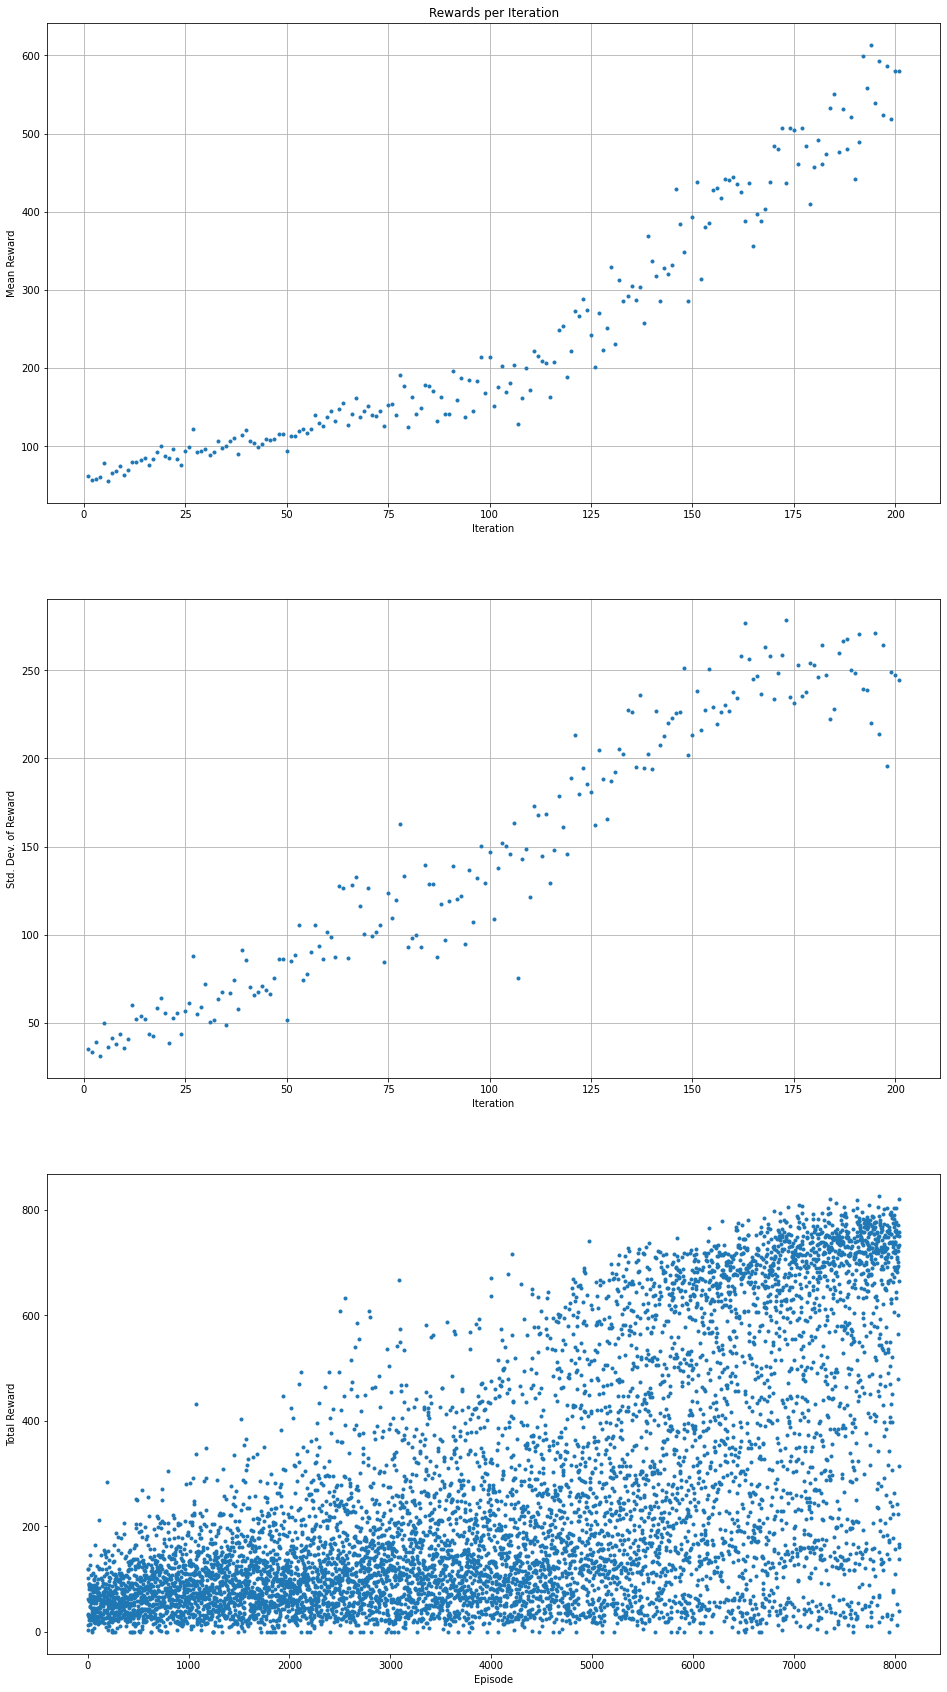

In [24]:
# Reward graph per episode
max_episode = np.max(sim_df['episode'])
max_iteration = np.max(sim_df_iterations['iteration'])
print('Number of episodes = ', max_episode)
print('Number of complete iterations = ', max_iteration)

total_reward_per_episode = list()
for epi in range(1, max_episode + 1):
    df_slice = sim_df[sim_df['episode'] == epi]
    total_reward_per_episode.append(np.sum(df_slice['reward']))

average_reward_per_iteration = list()
deviation_reward_per_iteration = list()

buffer_rew = list()
for val in total_reward_per_episode:
    buffer_rew.append(val)

    if len(buffer_rew) == EPISODES_PER_ITERATION:
        average_reward_per_iteration.append(np.mean(buffer_rew))
        deviation_reward_per_iteration.append(np.std(buffer_rew))
        # reset
        buffer_rew = list()

fig = plt.figure(figsize=(16, 10*3))
ax = fig.add_subplot(311)
ax.plot(np.arange(len(average_reward_per_iteration))+1, average_reward_per_iteration, '.')
ax.set_title('Rewards per Iteration')
ax.set_ylabel('Mean Reward')
ax.set_xlabel('Iteration')
plt.grid(True)

ax = fig.add_subplot(312)
ax.plot(np.arange(len(deviation_reward_per_iteration))+1, deviation_reward_per_iteration, '.')
ax.set_ylabel('Std. Dev. of Reward')
ax.set_xlabel('Iteration')
plt.grid(True)

ax = fig.add_subplot(313)
ax.plot(np.arange(len(total_reward_per_episode))+1, total_reward_per_episode, '.')
ax.set_ylabel('Total Reward')
ax.set_xlabel('Episode')
plt.grid(False)

# Check Correlation Between Steps and Lap Times
- Plot steps vs lap times to gauge the potential increasae in lap time for every step taken; this can also be used to extrapolate the target number of steps needed in order to achieve a certain lap time

# Check that Rewards Correlate with Performance
- Plot rewards vs lap times as a sanity check for our Reward Function logic

# Determine the Performance Envelope of the Model
- Plot a histogram of lap times to work out statistically the average and best-case lap times (also helps to confirm if the lap times within the performance envelope of the model resembles a normal distribution)
- The -2 and -3 Std Dev markers show the potential best-case lap times for the model

Completed Episodes: 1007
112
Mean: 26.677630
Variance: 2.566655
StdDev: 1.602078
-2 StdDev: 23.873288
-3 StdDev: 23.101983


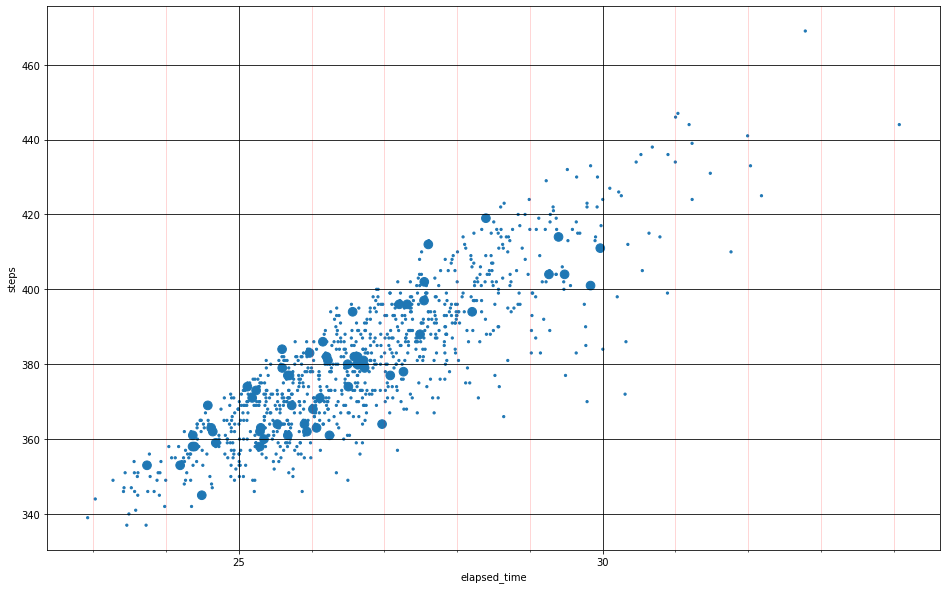

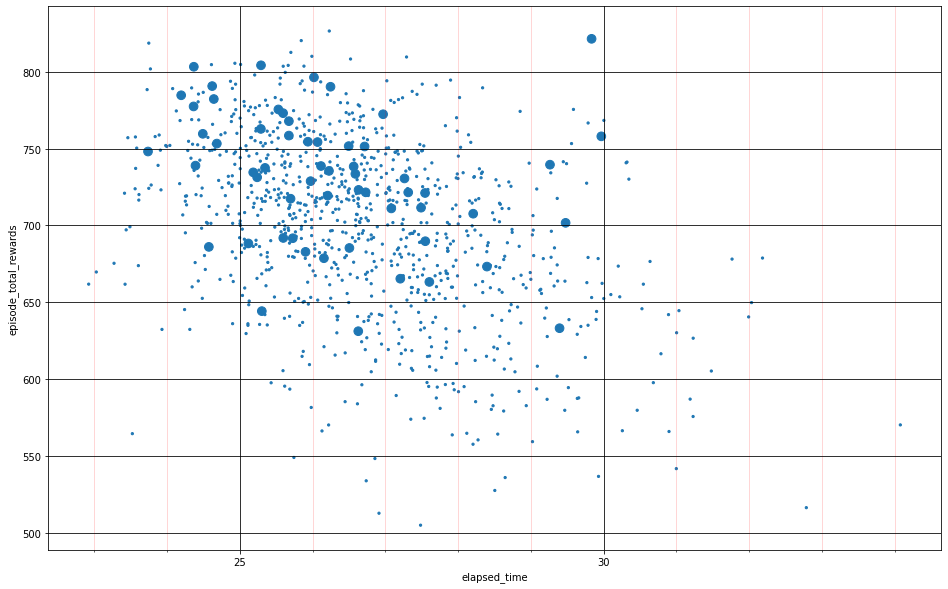

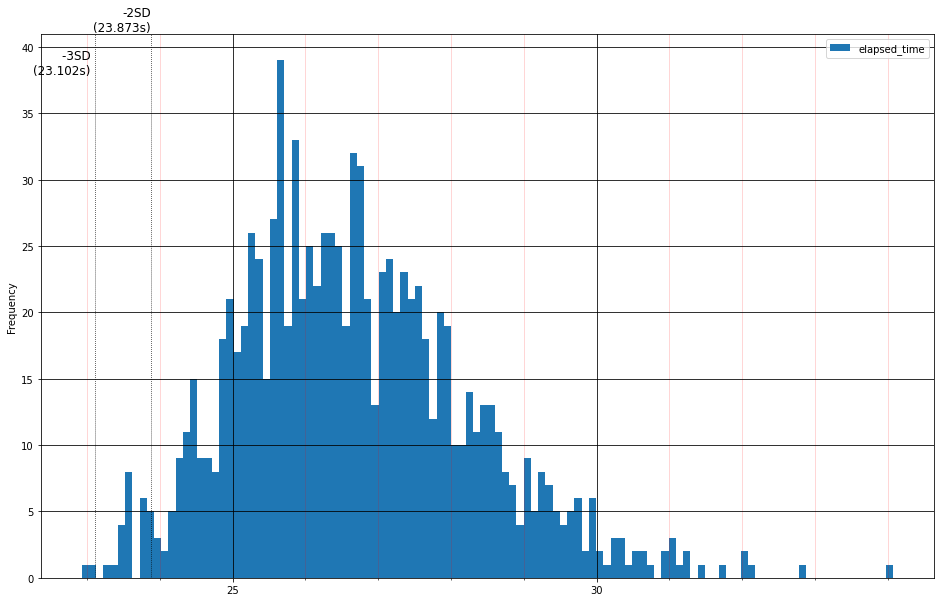

In [25]:
df_slice = sim_df_episodes[sim_df_episodes['status'] == 'lap_complete']
#df_slice = df_slice[df_slice['iteration'] <= 56]
max_iteration = df_slice['iteration'].max()

scatter_size = list()
for iter in df_slice['iteration']:
        if (iter > (max_iteration - 3)):
            scatter_size.append(75)
        else:
            scatter_size.append(5)
    
completed_episode_count = df_slice['episode'].count()
print('Completed Episodes: %d' % completed_episode_count)
if completed_episode_count > 0:
    axes = df_slice.plot(figsize=(16,10), fontsize=10, kind='scatter', s=scatter_size, x='elapsed_time', y='steps')
    axes.set_xlabel(axes.get_xlabel(), fontsize=10)
    axes.set_ylabel(axes.get_ylabel(), fontsize=10)
    axes.xaxis.set_major_locator(MultipleLocator(5.0))
    axes.xaxis.set_minor_locator(MultipleLocator(1.0))
    axes.grid(True, which='major', color='black')
    axes.grid(True, which='minor', color='red', alpha=0.2)
    
    axes = df_slice.plot(figsize=(16,10), fontsize=10, kind='scatter', s=scatter_size, x='elapsed_time', y='episode_total_rewards')
    axes.set_xlabel(axes.get_xlabel(), fontsize=10)
    axes.set_ylabel(axes.get_ylabel(), fontsize=10)
    axes.xaxis.set_major_locator(MultipleLocator(5.0))
    axes.xaxis.set_minor_locator(MultipleLocator(1.0))
    axes.grid(True, which='major', color='black')
    axes.grid(True, which='minor', color='red', alpha=0.2)
    
    w = 0.1
    n = math.ceil((df_slice['elapsed_time'].max() - df_slice['elapsed_time'].min())/w)
    if n == 0:
        n = 1
    print(n)
    axes = df_slice.plot(figsize=(16,10), fontsize=10, kind='hist', bins=n, x='steps', y='elapsed_time')
    axes.set_xlabel(axes.get_xlabel(), fontsize=10)
    axes.set_ylabel(axes.get_ylabel(), fontsize=10)
    axes.xaxis.set_major_locator(MultipleLocator(5.0))
    axes.xaxis.set_minor_locator(MultipleLocator(1.0))
    axes.grid(True, which='major', color='black')
    axes.grid(True, which='minor', color='red', alpha=0.2)

    data_minus2sd = np.percentile(df_slice['elapsed_time'], 2.28)
    data_minus3sd = np.percentile(df_slice['elapsed_time'], 0.13)

    print('Mean: %f' % (np.mean(df_slice['elapsed_time'])))
    print('Variance: %f' % (np.var(df_slice['elapsed_time'])))
    print('StdDev: %f' % (np.std(df_slice['elapsed_time'])))
    print('-2 StdDev: %f' % (data_minus2sd))
    print('-3 StdDev: %f' % (data_minus3sd))
    
    axes.axvline(x=data_minus2sd,linestyle='dotted',linewidth=0.75,color='black')
    axes.text(data_minus2sd, axes.get_ylim()[1], '-2SD\n(%0.3fs)' % data_minus2sd, ha='right', va='bottom', size=12)

    axes.axvline(x=data_minus3sd,linestyle='dotted',linewidth=0.75,color='black')
    axes.text(data_minus3sd, axes.get_ylim()[1], '\n-3SD \n(%0.3fs) ' % data_minus3sd, ha='right', va='top', size=12)


# Identify Potential Model Checkpoints for Cloning and Race Submission
- Plot the top quartile (p25) lap times vs iterations to identify potential model checkpoints and to look out for trade-offs between speed and stability over time
- Use the mean lap times per iteration among the p25 population to see through the noise
- Find the best lap times among the p25 population as an additional consideration

Completed Episodes: 1007
p25: 25.564s
Completed Episodes (p25): 252


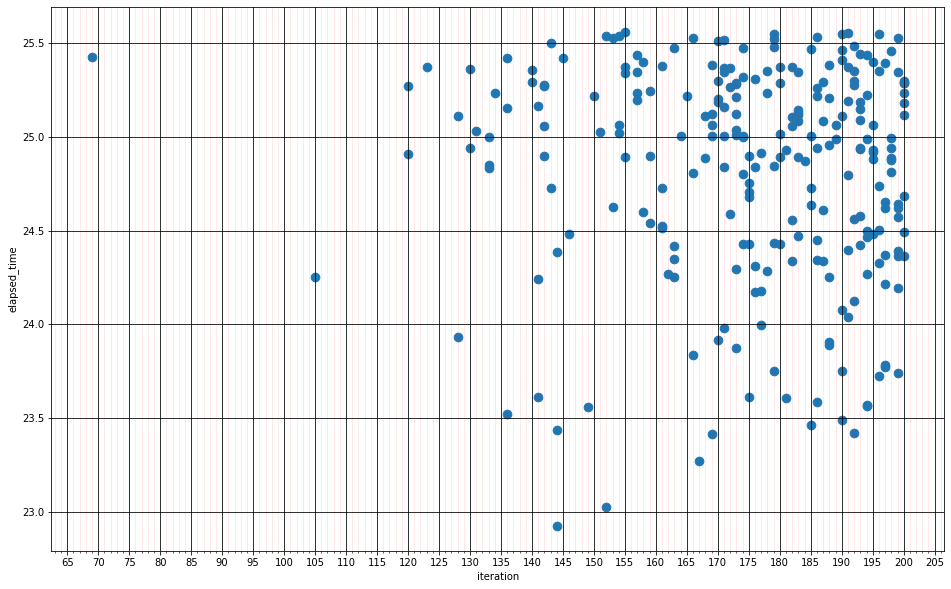

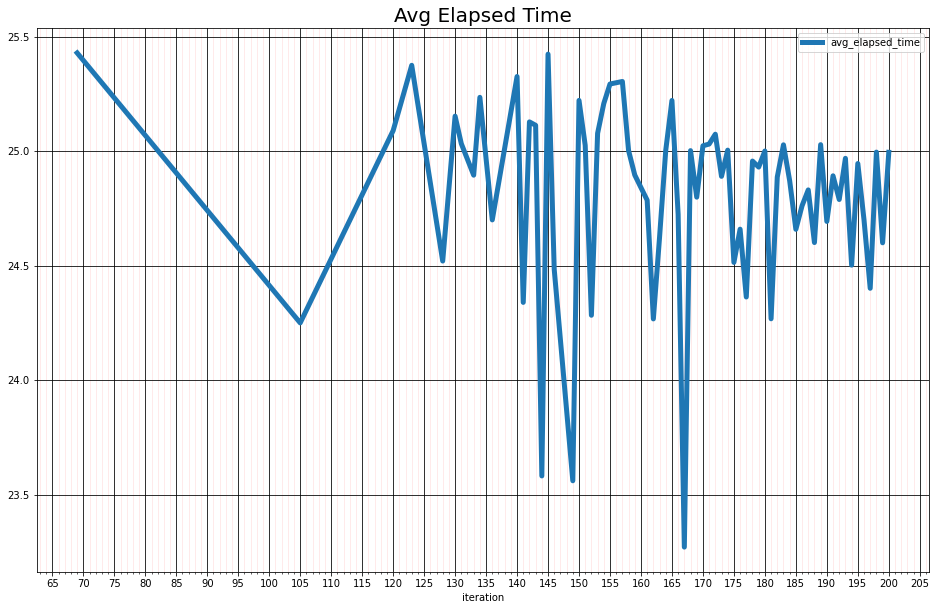

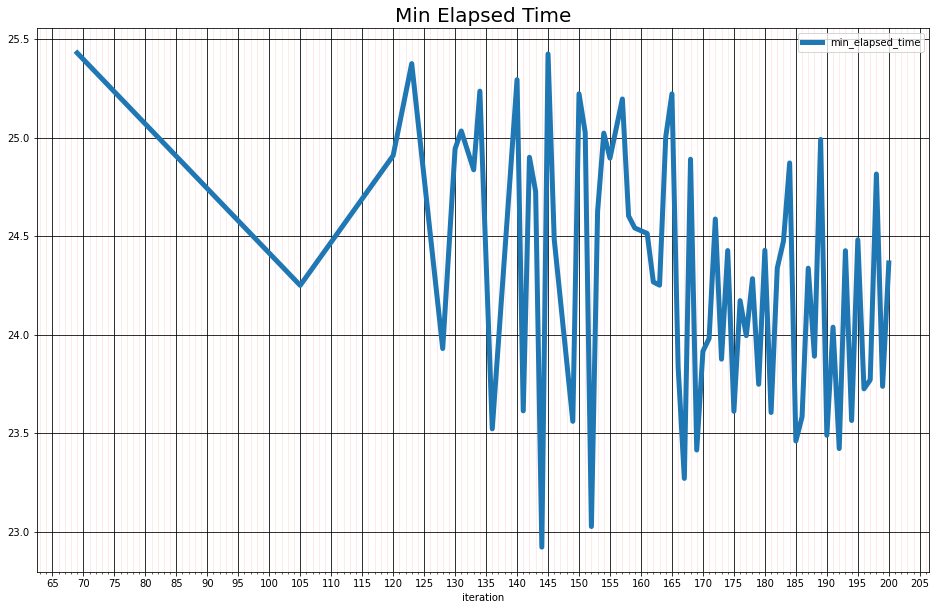

In [26]:
df_slice = sim_df_episodes[sim_df_episodes['status'] == 'lap_complete']
completed_episode_count = df_slice['episode'].count()
print('Completed Episodes: %d' % completed_episode_count)
if completed_episode_count > 0:
    elapsed_time_p25 = df_slice['elapsed_time'].quantile(.25)
    print('p25: %.3fs' % elapsed_time_p25)

    df_slice = df_slice[df_slice['elapsed_time'] <= elapsed_time_p25]
    completed_episode_p25_count = df_slice['episode'].count()
    print('Completed Episodes (p25): %d' % completed_episode_p25_count)
    if completed_episode_p25_count > 0:
        axes = df_slice.plot(figsize=(16,10), fontsize=10, kind='scatter', s=75, x='iteration', y='elapsed_time')
        axes.set_xlabel(axes.get_xlabel(), fontsize=10)
        axes.set_ylabel(axes.get_ylabel(), fontsize=10)
        axes.xaxis.set_major_locator(MultipleLocator(5.0))
        axes.xaxis.set_minor_locator(MultipleLocator(1.0))
        axes.grid(True, which='major', color='black')
        axes.grid(True, which='minor', color='red', alpha=0.1)
        
        df_slice["avg_elapsed_time"] = df_slice.groupby("iteration")["elapsed_time"].transform("mean")
        df_slice["min_elapsed_time"] = df_slice.groupby("iteration")["elapsed_time"].transform("min")

        axes = df_slice.plot(figsize=(16,10), fontsize=10, kind='line', linewidth=5, x='iteration', y='avg_elapsed_time')
        axes.set_xlabel(axes.get_xlabel(), fontsize=10)
        axes.set_ylabel(axes.get_ylabel(), fontsize=10)
        axes.xaxis.set_major_locator(MultipleLocator(5.0))
        axes.xaxis.set_minor_locator(MultipleLocator(1.0))
        axes.grid(True, which='major', color='black')
        axes.grid(True, which='minor', color='red', alpha=0.1)
        axes.set_title('Avg Elapsed Time', fontsize=20)
        
        axes = df_slice.plot(figsize=(16,10), fontsize=10, kind='line', linewidth=5, x='iteration', y='min_elapsed_time')
        axes.set_xlabel(axes.get_xlabel(), fontsize=10)
        axes.set_ylabel(axes.get_ylabel(), fontsize=10)
        axes.xaxis.set_major_locator(MultipleLocator(5.0))
        axes.xaxis.set_minor_locator(MultipleLocator(1.0))
        axes.grid(True, which='major', color='black')
        axes.grid(True, which='minor', color='red', alpha=0.1)
        axes.set_title('Min Elapsed Time', fontsize=20)
        

# Plot (Rewards vs Entropy vs Lap Progress) per Iteration

In [27]:
def plot_reward_graph(df_slice_iterations=sim_df_iterations, df_slice_entropy=trn_df_entropy):
    font_size=16
    if(len(df_slice_iterations)>0):
        fig = plt.figure(figsize=(16, 10))
        ax = plt.gca()  # gca stands for 'get current axis'
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # force integer labels on x-axis
        ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

        df_slice_entropy.plot(kind='line',x='iteration',y='avg_entropy',label='',linewidth=1,color='red',alpha=0.3,fontsize=font_size,ax=ax)
        df_slice_entropy.plot(kind='line',linestyle='solid',x='iteration',y='avg_entropy_SMA3',linewidth=1.5,color='red',fontsize=font_size,ax=ax)

        df_slice_iterations.plot(kind='line',x='iteration',y='total_rewards_normalized',label='',linewidth=1,color='green',alpha=0.3,fontsize=font_size,ax=ax2)
        df_slice_iterations.plot(kind='line',linestyle='solid',x='iteration',y='total_rewards_normalized_SMA3',linewidth=1.5,color='green',fontsize=font_size,ax=ax2)

        df_slice_iterations.plot(kind='line',x='iteration',y='avg_progress',label='',linewidth=1,color='blue',alpha=0.3,fontsize=font_size,ax=ax2)
        df_slice_iterations.plot(kind='line',linestyle='dashdot',x='iteration',y='avg_progress_SMA3',linewidth=3,color='blue',fontsize=font_size,ax=ax2)

        ax.legend().remove()
        ax.set_xlabel(ax.get_xlabel(), fontsize=font_size)
        ax.set_ylabel('Entropy', fontsize=font_size)

        ax2.legend().remove()
        ax2.set_ylabel('Normalized Rewards / Progress (%) / Completed Laps (%)', fontsize=font_size)

        start_time = df_slice_iterations["start_time"].min()
        end_time = df_slice_iterations["end_time"].max()
        elapsed_time = end_time - start_time
        elapsed_time_hrs = elapsed_time / 3600
        plt.plot([], [], ' ', label='Iterations: %d' % df_slice_iterations["iteration"].max())
        plt.plot([], [], ' ', label='Elapsed Time: %0.2fhrs' % elapsed_time_hrs)

        fig.legend(loc="lower center", borderaxespad=0.1, ncol=4, fontsize=14, title="Legend")
        plt.subplots_adjust(bottom=0.15)

        max_rewards_iter = df_slice_iterations['total_rewards_normalized_SMA3'].idxmax()
        if (max_rewards_iter >= 0):
            xmax_rewards = df_slice_iterations['iteration'][max_rewards_iter]
            ymax_rewards = df_slice_iterations['total_rewards_normalized_SMA3'].max()
            plt.axvline(x=xmax_rewards,linestyle='dotted',linewidth=0.75,color='black')
            plt.axhline(y=ymax_rewards,linestyle='dotted',linewidth=0.75,color='black',alpha=0.3)
            plt.gca().text(xmax_rewards*0.995, ymax_rewards*1.005, 'Max Rewards @ %d' % xmax_rewards, ha='right', va='bottom', size=font_size)

        max_progress_iter = df_slice_iterations['avg_progress_SMA3'].idxmax()
        if (max_progress_iter >= 0):
            xmax_progress = df_slice_iterations['iteration'][max_progress_iter]
            ymax_progress = df_slice_iterations['avg_progress_SMA3'].max()
            plt.axvline(x=xmax_progress,linestyle='dotted',linewidth=0.75,color='black')
            plt.axhline(y=ymax_progress,linestyle='dotted',linewidth=0.75,color='black',alpha=0.3)
            plt.gca().text(xmax_progress*0.995, ymax_progress*1.005, 'Max Progress @ %d' % xmax_progress, ha='right', va='bottom', size=font_size)

        plt.yticks(np.arange(0, 105, step=10))
        plt.show()
        if (max_rewards_iter >= 0):
            print ("Iteration with Max Total Rewards (SMA3): %d" % (xmax_rewards))
        print ("Elapsed Time: %0.2fs (%0.2fhrs)" % (elapsed_time, elapsed_time_hrs))

# Plot Entropy vs Rewards/Progress as an Additional Indicator for Convergence
- Uses the SMA3 aggregate data to smoothen the graph plot

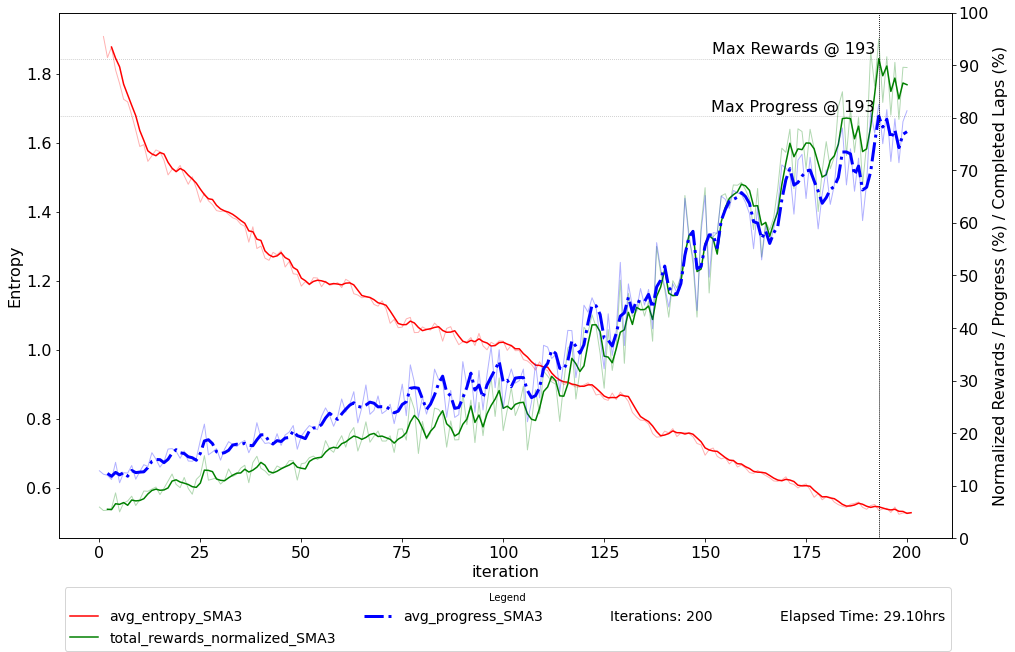

Iteration with Max Total Rewards (SMA3): 193
Elapsed Time: 104751.26s (29.10hrs)


In [28]:
plot_reward_graph()

# Plot the Lap-Completion Ratio of Episodes in Each Iteration to Gauge the Consistency of the Model
- Uses the SMA3 aggregate data to smoothen the graph plot

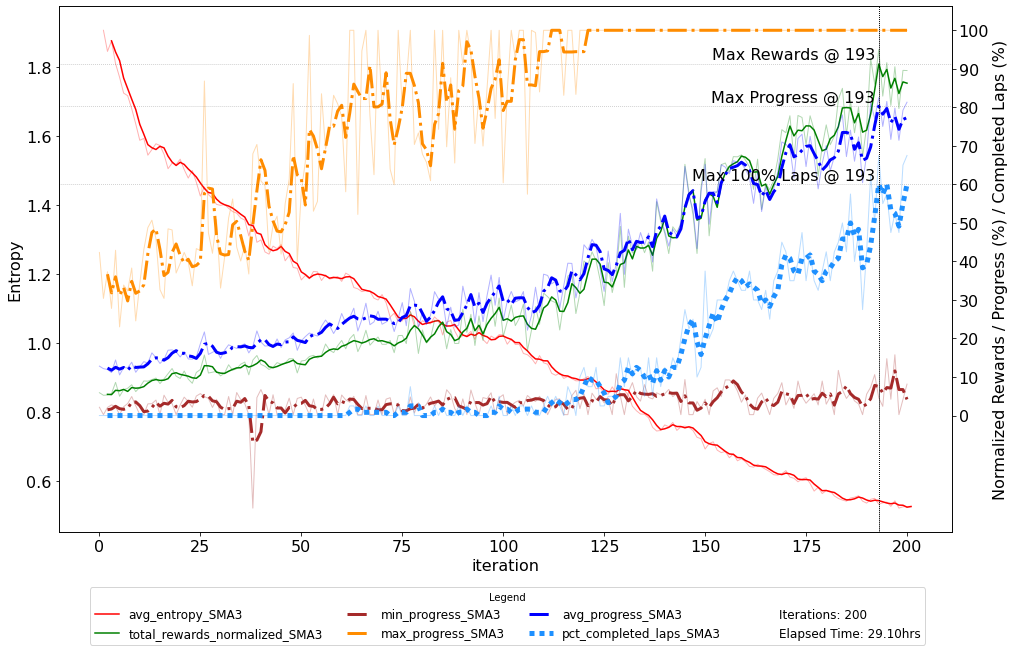

Iteration with Max Pct Completed Laps (SMA3): 193 (Value 60.0)
Iteration with Max Total Rewards (SMA3): 193
Elapsed Time: 104751.26s (29.10hrs)


In [29]:
font_size=16
if(len(sim_df_iterations)>0):
    fig = plt.figure(figsize=(16, 10))
    ax = plt.gca()  # gca stands for 'get current axis'
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # force integer labels on x-axis
    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

    trn_df_entropy.plot(kind='line',x='iteration',y='avg_entropy',label='',linewidth=1,color='red',alpha=0.3,fontsize=font_size,ax=ax)
    trn_df_entropy.plot(kind='line',linestyle='solid',x='iteration',y='avg_entropy_SMA3',linewidth=1.5,color='red',fontsize=font_size,ax=ax)

    sim_df_iterations.plot(kind='line',x='iteration',y='total_rewards_normalized',label='',linewidth=1,color='green',alpha=0.3,fontsize=font_size,ax=ax2)
    sim_df_iterations.plot(kind='line',linestyle='solid',x='iteration',y='total_rewards_normalized_SMA3',linewidth=1.5,color='green',fontsize=font_size,ax=ax2)

    sim_df_iterations.plot(kind='line',x='iteration',y='min_progress',label='',linewidth=1,color='brown',alpha=0.3,fontsize=font_size,ax=ax2)
    sim_df_iterations.plot(kind='line',linestyle='dashdot',x='iteration',y='min_progress_SMA3',linewidth=3,color='brown',fontsize=font_size,ax=ax2)

    sim_df_iterations.plot(kind='line',x='iteration',y='max_progress',label='',linewidth=1,color='darkorange',alpha=0.3,fontsize=font_size,ax=ax2)
    sim_df_iterations.plot(kind='line',linestyle='dashdot',x='iteration',y='max_progress_SMA3',linewidth=3,color='darkorange',fontsize=font_size,ax=ax2)

    sim_df_iterations.plot(kind='line',x='iteration',y='avg_progress',label='',linewidth=1,color='blue',alpha=0.3,fontsize=font_size,ax=ax2)
    sim_df_iterations.plot(kind='line',linestyle='dashdot',x='iteration',y='avg_progress_SMA3',linewidth=3,color='blue',fontsize=font_size,ax=ax2)

    sim_df_iterations.plot(kind='line',x='iteration',y='pct_completed_laps',label='',linewidth=1,color='dodgerblue',alpha=0.3,fontsize=font_size,ax=ax2)
    sim_df_iterations.plot(kind='line',linestyle=(0,(1,1)),x='iteration',y='pct_completed_laps_SMA3',linewidth=5,color='dodgerblue',fontsize=font_size,ax=ax2)

    ax.legend().remove()
    ax.set_xlabel(ax.get_xlabel(), fontsize=font_size)
    ax.set_ylabel('Entropy', fontsize=font_size)
    ax2.legend().remove()
    ax2.set_ylabel('Normalized Rewards / Progress (%) / Completed Laps (%)', fontsize=font_size)

    start_time = sim_df_iterations["start_time"].min()
    end_time = sim_df_iterations["end_time"].max()
    elapsed_time = end_time - start_time
    elapsed_time_hrs = elapsed_time / 3600
    plt.plot([], [], ' ', label='Iterations: %d' % sim_df_iterations["iteration"].max())
    plt.plot([], [], ' ', label='Elapsed Time: %0.2fhrs' % elapsed_time_hrs)

    fig.legend(loc="lower center", borderaxespad=0.1, ncol=4, fontsize=12, title="Legend")
    plt.subplots_adjust(bottom=0.15)

    first_100pct_iteration = sim_df_iterations[sim_df_iterations["max_progress_SMA3"] >= 100.0]['iteration'].min()
    if first_100pct_iteration > 0:
        plt.axvline(x=first_100pct_iteration,linestyle='dotted',linewidth=0.75,color='black')
        plt.gca().text(first_100pct_iteration*0.995, ax2.get_ylim()[0], '100%% Laps @ %d' % first_100pct_iteration, ha='right', va='bottom', size=font_size)

    max_rewards_iter = sim_df_iterations['total_rewards_normalized_SMA3'].idxmax()
    if (max_rewards_iter >= 0):
        xmax_rewards = sim_df_iterations['iteration'][sim_df_iterations['total_rewards_normalized_SMA3'].idxmax()]
        ymax_rewards = sim_df_iterations['total_rewards_normalized_SMA3'].max()
        plt.axvline(x=xmax_rewards,linestyle='dotted',linewidth=0.75,color='black')
        plt.axhline(y=ymax_rewards,linestyle='dotted',linewidth=0.75,color='black',alpha=0.3)
        plt.gca().text(xmax_rewards*0.995, ymax_rewards*1.005, 'Max Rewards @ %d' % xmax_rewards, ha='right', va='bottom', size=font_size)

    max_progress_iter = sim_df_iterations['avg_progress_SMA3'].idxmax()
    if (max_progress_iter >= 0):
        xmax_progress = sim_df_iterations['iteration'][sim_df_iterations['avg_progress_SMA3'].idxmax()]
        ymax_progress = sim_df_iterations['avg_progress_SMA3'].max()
        plt.axvline(x=xmax_progress,linestyle='dotted',linewidth=0.75,color='black')
        plt.axhline(y=ymax_progress,linestyle='dotted',linewidth=0.75,color='black',alpha=0.3)
        plt.gca().text(xmax_progress*0.995, ymax_progress*1.005, 'Max Progress @ %d' % xmax_progress, ha='right', va='bottom', size=font_size)

    max_completed_iter = sim_df_iterations['pct_completed_laps_SMA3'].idxmax()
    if (max_completed_iter >= 0):
        xmax_completed_laps = sim_df_iterations['iteration'][sim_df_iterations['pct_completed_laps_SMA3'].idxmax()]
        ymax_completed_laps = sim_df_iterations['pct_completed_laps_SMA3'].max()
        plt.axvline(x=xmax_completed_laps,linestyle='dotted',linewidth=0.75,color='black')
        plt.axhline(y=ymax_completed_laps,linestyle='dotted',linewidth=0.75,color='black',alpha=0.3)
        plt.gca().text(xmax_completed_laps*0.995, ymax_completed_laps*1.005, 'Max 100%% Laps @ %d' % xmax_completed_laps, ha='right', va='bottom', size=font_size)
    
    plt.yticks(np.arange(0, 105, step=10))
    plt.show()

    if (first_100pct_iteration >= 0):
        text= "Iteration with First Completed Laps (SMA3): {:}".format(first_100pct_iteration)
        print(text)

    if (max_completed_iter >= 0):
        text= "Iteration with Max Pct Completed Laps (SMA3): {:} (Value {:})".format(xmax_completed_laps, ymax_completed_laps)
        print(text)

    if (max_rewards_iter >= 0):
        text= "Iteration with Max Total Rewards (SMA3): {:}".format(xmax_rewards)
        print(text)

    print ("Elapsed Time: %0.2fs (%0.2fhrs)" % (elapsed_time, elapsed_time_hrs))


# Load & Visualise the Track Waypoints

If the track is not found, download newer tracks from the [deepracer-simapp bundle](https://github.com/aws-deepracer-community/deepracer-simapp/tree/master/bundle/deepracer_simulation_environment/share/deepracer_simulation_environment/routes) maintained by the community, and copy them into the `tracks` folder

In [30]:
# List the available tracks vs expected WORLD_NAME
print('WORLD_NAME: %s' % WORLD_NAME)
ListFiles = [f for f in listdir("tracks/") if isfile(join("tracks/", f))]
ListFiles
print('Available Tracks: %s' % ListFiles)

WORLD_NAME: Austin
Available Tracks: ['AWS_track.npy', 'Albert.npy', 'AmericasGeneratedInclStart.npy', 'Aragon.npy', 'Austin.npy', 'Belille.npy', 'Bowtie_track.npy', 'Canada_Eval.npy', 'Canada_Training.npy', 'ChampionshipCup2019_track.npy', 'China_eval_track.npy', 'China_track.npy', 'FS_June2020.npy', 'H_track.npy', 'July_2020.npy', 'LGSWide.npy', 'London_Loop_Train.npy', 'Mexico_track.npy', 'Mexico_track_eval.npy', 'Monaco.npy', 'New_York_Eval_Track.npy', 'New_York_Track.npy', 'Oval_track.npy', 'Singapore.npy', 'Spain_track.npy', 'Straight_track.npy', 'Tokyo_Training_track.npy', 'Vegas_track.npy', 'Virtual_May19_Train_track.npy', 'reInvent2019_track.npy', 'reInvent2019_wide.npy', 'reInvent2019_wide_mirrored.npy', 'reinvent_base.npy']


In [31]:
fpath = "./racelines/Austin-1500-4-2020-11-26-203913.npy"

racing_track = np.load(fpath)

# Convert np array to list and remove last point because it is the same point as the first one
#racing_track = racing_track.tolist()[:]

In [32]:
def get_track_waypoints(track_name):
    return np.load("tracks/%s.npy" % track_name)
    
waypoints = get_track_waypoints(WORLD_NAME)
waypoints.shape

(224, 6)

In [33]:
def plot_points(ax, points):
    ax.scatter(points[:-1,0], points[:-1,1], s=1)
    for i,p in enumerate(points):
        if i % 5 == 0:
            ax.annotate(i, (p[0], p[1]))
        #else:
            #ax.annotate('*', (p[0], p[1]), color=color)

def plot_line(ax, ob, color):
    ob = LineString(ob)                                                
    x, y = ob.xy                                                                
    ax.plot(x, y, color=color, alpha=0.5, linewidth=3, solid_capstyle='round', zorder=2)

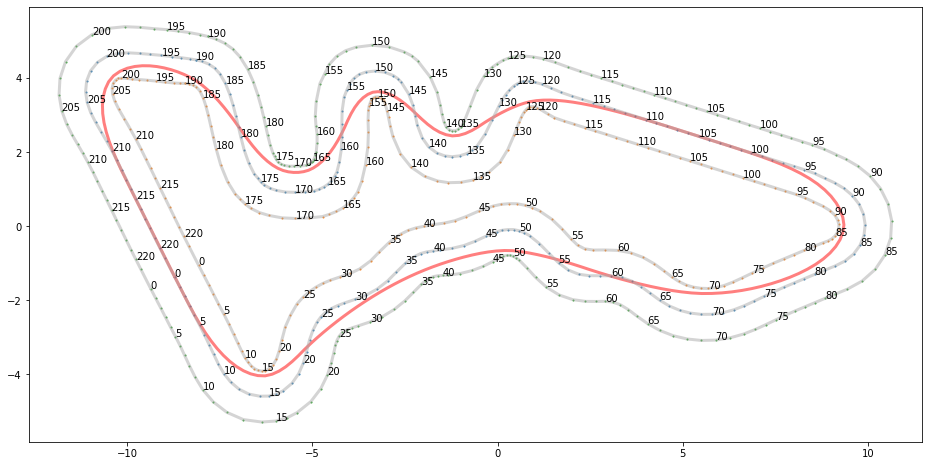

In [34]:
# Plot the results
fig, ax = plt.subplots(figsize=(16,8))


plot_line(ax, racing_track, 'red' )
plot_line(ax, waypoints[:,0:2], '#aaaaaa')
plot_line(ax, waypoints[:,2:4], '#aaaaaa')
plot_line(ax, waypoints[:,4:6], '#aaaaaa')

plot_points(ax, waypoints[:-1,0:2])
plot_points(ax, waypoints[:-1,2:4])
plot_points(ax, waypoints[:-1,4:6])
ax.axis('equal')
plt.show()

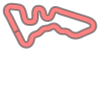

In [35]:
l_center_line = LineString(waypoints[:,0:2])
l_inner_border = LineString(waypoints[:,2:4])
l_outer_border = LineString(waypoints[:,4:6])
road_poly = Polygon(np.vstack((l_outer_border, np.flipud(l_inner_border))))
road_poly

In [36]:
# rescale waypoints to centimeter scale
center_line = waypoints[:,0:2] *100
inner_border = waypoints[:,2:4] *100
outer_border = waypoints[:,4:6] *100
racing_track = racing_track[:] *100

In [37]:
# add x_offset to bring everything to the positive axis

x_offset = int(sim_df['x'].min())
if x_offset > 0: # if positive, just keep it the same
    x_offset = 0
x_offset = abs(x_offset)

inner_border[:,:] = inner_border[:,:] + x_offset
center_line[:,:] = center_line[:,:] + x_offset
outer_border[:,:] = outer_border[:,:] + x_offset

racing_track[:,:] = racing_track[:,:] + x_offset

In [38]:
# add y_offset to bring everything to the positive axis

y_offset = int(sim_df['y'].min())
if y_offset > 0: # if positive, just keep it the same
    y_offset = 0
y_offset = abs(y_offset)

inner_border[:,1] = inner_border[:,1] + y_offset - x_offset
center_line[:,1] = center_line[:,1] + y_offset - x_offset
outer_border[:,1] = outer_border[:,1] + y_offset - x_offset
racing_track[:,1] = racing_track[:,1] + y_offset - x_offset

In [39]:
# track dimensions
track_x_max = outer_border[:,:].max()
track_y_max = outer_border[:,1].max()
print ('Track Dimensions: (%f, %f)' % (track_x_max, track_y_max))

# simulation dimensions
sim_x_max = sim_df['x'].max() + x_offset
sim_y_max = sim_df['y'].max() + y_offset
print ('Simulation Dimensions: (%f, %f)' % (sim_x_max, sim_y_max))

# plot dimensions
plot_x_max = int(math.ceil(max(track_x_max, sim_x_max)/50) * 50)
plot_y_max = int(math.ceil(max(track_y_max, sim_y_max)/50) * 50)
print ('Plot Dimensions: (%d, %d)' % (plot_x_max, plot_y_max))

Track Dimensions: (2283.776970, 1109.030504)
Simulation Dimensions: (2319.660000, 1140.260000)
Plot Dimensions: (2350, 1150)


In [40]:
def plot_coords(ax, ob):
    x, y = ob.xy
    ax.plot(x, y, '.', color='#999999', zorder=1)

def plot_line(ax, ob):
    x, y = ob.xy
    ax.plot(x, y, color='cyan', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)

def print_border(ax, waypoints, inner_border_waypoints, outer_border_waypoints, racing_track):
    line = LineString(waypoints)
    plot_coords(ax, line)
    plot_line(ax, line)

    line = LineString(inner_border_waypoints)
    plot_coords(ax, line)
    plot_line(ax, line)

    line = LineString(outer_border_waypoints)
    plot_coords(ax, line)
    plot_line(ax, line)

    line = LineString(racing_track)
    plot_coords(ax, line)
    plot_line(ax, line)

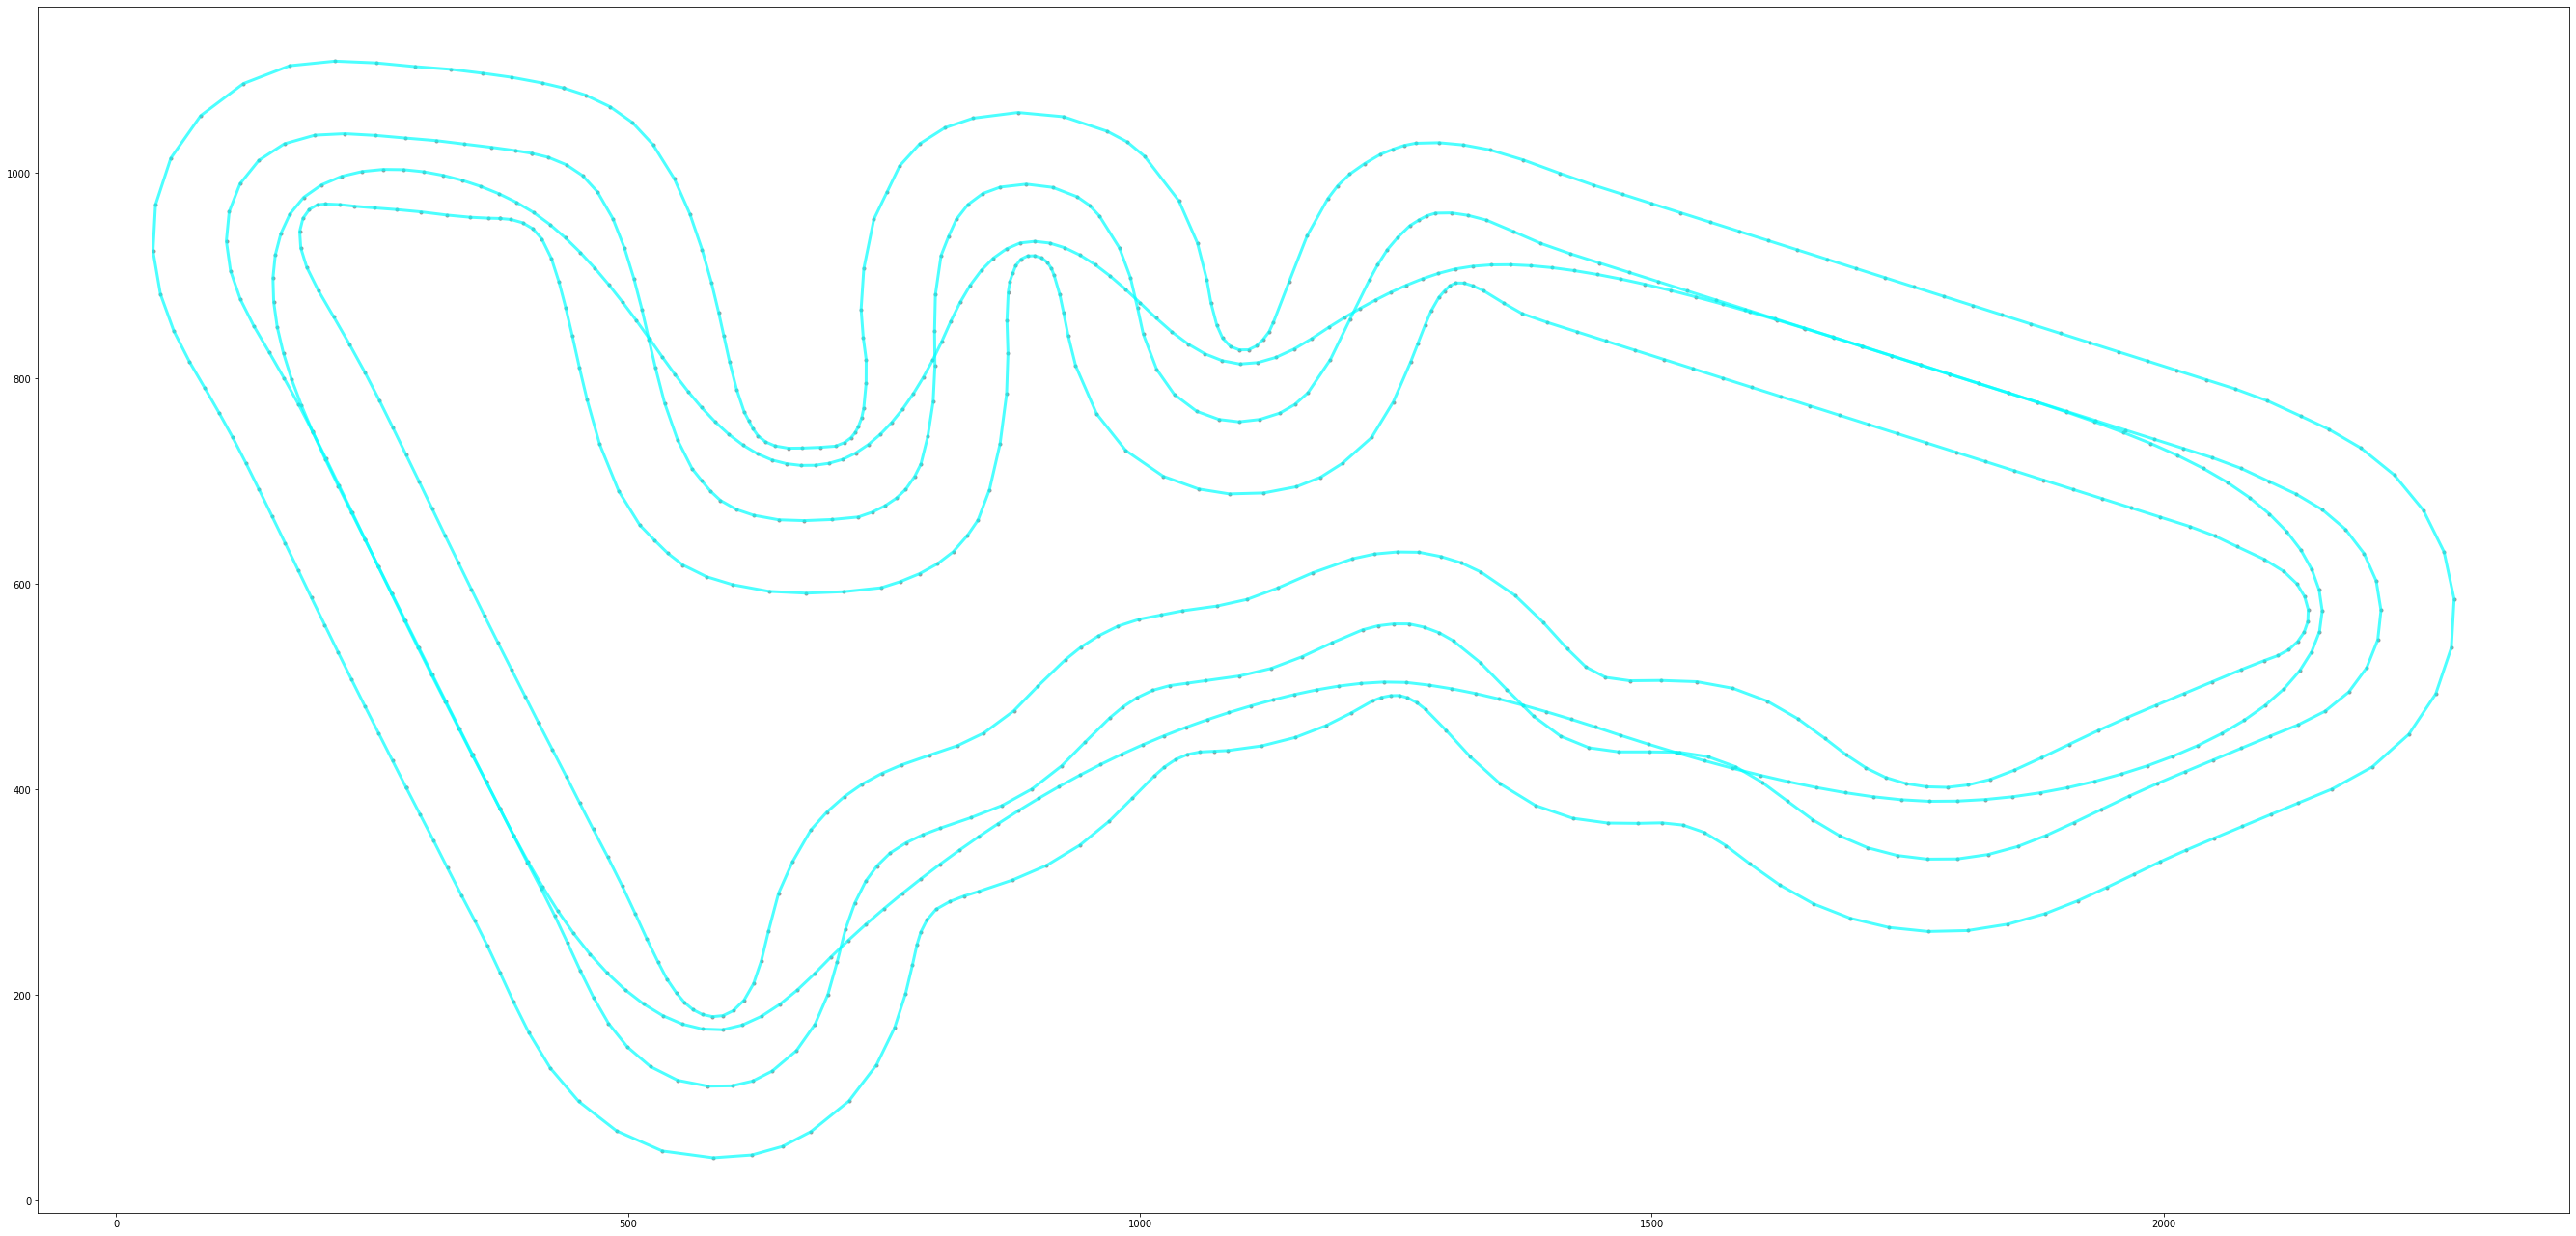

In [41]:
# Plot the track layout with the right scale and size

fig = plt.figure(figsize=(plot_x_max/50, plot_y_max/50))
ax = fig.add_subplot(111)
print_border(ax, center_line, inner_border, outer_border, racing_track)

# Plot Actions Utilisation Heatmap for the Most Recent Iteration to Tweak the Action Space
- Use a heatmap to visualise the relative use of each action in the action space, in order to identify actions to consolidate / remove

In [42]:
def plot_count_on_action(df):
    actionspace = np.zeros((int((action_max_speed+(action_min_speed/3)) * 10 * 1.1), int(action_steering_range * 1.1)))
    for index, row in df.iterrows():
        x = int(row["steer"])+(int(action_steering_range * 1.1 / 2))
        y = int(row["throttle"]*10)
        actionspace[y,x] += 1
        
    fig = plt.figure(1, figsize=(16,10))
    ax = fig.add_subplot(111)
    return actionspace

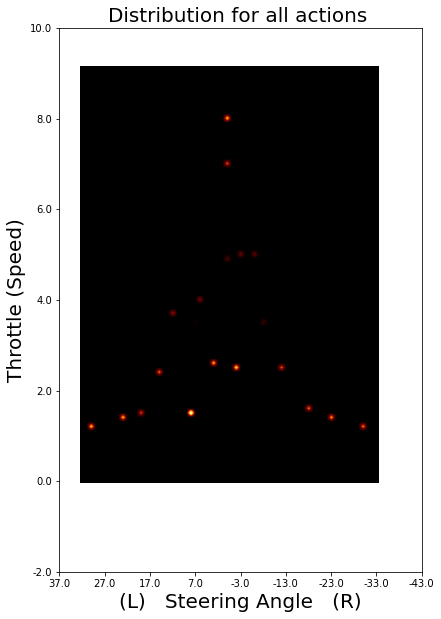

In [43]:
max_iteration = sim_df['iteration'].max()
df_slice = sim_df[sim_df['iteration'] == max_iteration]

track = plot_count_on_action(df_slice)
plt.title("Distribution for all actions ", fontsize=20)
im = plt.imshow(track, cmap='afmhot', interpolation='bilinear', origin="lower") 

ax = plt.gca()  # gca stands for 'get current axis'
ax.set_xlabel('(L)   Steering Angle   (R)', fontsize=20)
ax.set_ylabel('Throttle (Speed)', fontsize=20)

xlabels = ax.get_xticks()
ax.set_xticks(xlabels)
new_xlabels = [(x-int(action_steering_range * 1.1 / 2)) for x in xlabels]
ax.xaxis.set_ticklabels(new_xlabels)
ax.set_xlim(xlabels[-1], xlabels[0])

ylabels = ax.get_yticks()
ax.set_yticks(ylabels)
new_ylabels = [(y/10) for y in ylabels]    
ax.yaxis.set_ticklabels(new_ylabels)

plt.show()

# Plot Avg Speed and Steering at Each Waypoint (Horizontal) for the Most Recent Iteration
- Visualise the Avg Speed and Steering Angle at each waypoint (horizontally), to identify inefficiencies in driving behaviour

In [44]:
def plot_speedsteering_per_waypoint_h(df):
    max_waypoint = df['closest_waypoint'].max()
    print ('max_waypoint: %d' % max_waypoint)
    
    max_steering = max(abs(df['steer'].min()), abs(df['steer'].max()))
    max_speed = df['throttle'].max()
    fig = plt.figure(figsize=(25.6, 16))
    
    plt.xticks(np.arange(0, max_waypoint+1, 10.0), fontsize=20)
    plt.xlabel('\nWaypoint', fontsize=20)
    plt.yticks(np.arange(math.floor(-max_steering), math.ceil(max_steering)+1, 5.0), fontsize=20)
    plt.ylabel('(L)   Steering Angle   (R)\n\n\n', fontsize=20, rotation=270)
    
    ax = plt.gca()  # gca stands for 'get current axis'
    ax.set_xticks(np.arange(5, max_waypoint+1, 10.0), minor=True)
    ax.tick_params(axis='x', which='major', length=10, direction='inout')
    ax.tick_params(axis='x', which='minor', length=5, direction='in')
    ax.set_ylim(math.floor(-max_steering), math.ceil(max_steering))
    ax.set_yticks(np.arange(math.floor(-max_steering)+1, math.ceil(max_steering)+1, 1.0), minor=True)
    ax.tick_params(axis='y', which='major', length=10, direction='inout')
    ax.tick_params(axis='y', which='minor', length=5, direction='in')


    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylabel('\n\n\nThrottle', fontsize=20, rotation=270)
    ax2.set_ylim(-max_speed, max_speed)
    ax2.set_yticks(np.arange(0, max_speed+0.5, 0.5))
    ax2.set_yticks(np.arange(0.1, max_speed+0.1, 0.1), minor=True)
    ax2.tick_params(axis='y', which='major', length=10, direction='inout', labelsize=20)
    ax2.tick_params(axis='y', which='minor', length=5, direction='in')

    wp_steering = list(range(max_waypoint + 1))
    wp_steering_count = list(range(max_waypoint + 1))
    wp_speed = list(range(max_waypoint + 1))
    wp_speed_count = list(range(max_waypoint + 1))
    
    for wp in range(0, max_waypoint+1):
        wp_steering[wp] = 0
        wp_steering_count[wp] = 0
        wp_speed[wp] = 0
        wp_speed_count[wp] = 0

    for index, row in df.iterrows():
        closest_waypoint = row['closest_waypoint']
        steering_angle = row['steer']
        wp_steering[closest_waypoint] += steering_angle
        wp_steering_count[closest_waypoint] += 1
        speed = row['throttle']
        wp_speed[closest_waypoint] += (speed)
        wp_speed_count[closest_waypoint] += 1
        
    for wp in range(0, max_waypoint+1):
        if (wp_steering_count[wp]>0):
            avg_steering_angle = wp_steering[wp] / wp_steering_count[wp]
            x = [wp, wp]
            y = [0, avg_steering_angle]
            ax.plot(x, y, marker = 'o', color='blue', alpha=0.5, linewidth=3)
        else:
            ax.plot([wp, wp], [0, 0], marker = 'o', color='blue', alpha=0.5, linewidth=3)
        if (wp_speed_count[wp]>0):
            avg_speed = wp_speed[wp] / wp_speed_count[wp]
            x = [wp, wp]
            y = [-avg_speed, avg_speed]
            ax2.plot(x, y, marker = 'x', color='red', alpha=0.5, linewidth=1)
        else:
            ax2.plot([wp, wp], [0, 0], marker = 'x', color='red', alpha=0.5, linewidth=1)




max_waypoint: 223


iteration  episode_in_iteration  episode  steps       x       y  \
1223996        201                     7     8047      1  481.13 -222.43   
1223997        201                     7     8047      2  482.01 -222.46   
1223998        201                     7     8047      3  483.97 -223.02   
1223999        201                     7     8047      4  487.94 -224.04   
1224000        201                     7     8047      5  491.52 -224.84   
1224001        201                     7     8047      6  498.45 -226.13   
1224002        201                     7     8047      7  507.52 -227.17   
1224003        201                     7     8047      8  514.38 -227.56   
1224004        201                     7     8047      9  526.17 -227.73   
1224005        201                     7     8047     10  541.53 -226.68   
1224006        201                     7     8047     11  549.71 -225.68   
1224007        201                     7     8047     12  567.57 -222.35   
1224008        201                     7     8047     13  588.76 -216.95   
1224009        201                     7     8047     14  601.42 -213.08   
1224010        201                     7     8047     15  618.81 -206.54   
1224011        201                     7     8047     16  637.34 -197.75   
1224012        201                     7     8047     17  660.82 -184.49   
1224013        201                     7     8047     18  673.26 -176.71   
1224014        201                     7     8047     19  693.47 -164.30   
1224015        201                     7     8047     20  705.91 -157.44   
1224016        201                     7     8047     21  722.24 -149.10   
1224017        201                     7     8047     22  734.80 -143.47   
1224018        201                     7     8047     23  751.75 -136.91   
1224019        201                     7     8047     24  764.27 -132.70   
1224020        201                     7     8047     25  785.51 -126.19   
1224021        201                     7     8047     26  796.25 -123.20   
1224022        201                     7     8047     27  815.18 -118.67   
1224023        201                     7     8047     28  832.46 -114.48   
1224024        201                     7     8047     29  848.14 -110.40   
1224025        201                     7     8047     30  866.48 -104.64   
1224026        201                     7     8047     31  878.64 -100.63   
1224027        201                     7     8047     32  891.13  -96.08   
1224028        201                     7     8047     33  907.33  -88.44   
1224029        201                     7     8047     34  915.01  -83.91   
1224030        201                     7     8047     35  926.96  -75.13   
1224031        201                     7     8047     36  934.90  -67.38   
1224032        201                     7     8047     37  940.82  -59.97   
1224033        201                     7     8047     38  946.93  -50.42   
1224034        201                     7     8047     39  949.81  -44.93   
1224035        201                     7     8047     40  954.34  -34.21   
1224036        201                     7     8047     41  956.57  -26.48   
1224037        201                     7     8047     42  957.94  -18.44   
1224038        201                     7     8047     43  958.91   -6.30   
1224039        201                     7     8047     44  958.65    1.99   
1224040        201                     7     8047     45  957.32   13.33   
1224041        201                     7     8047     46  955.76   20.31   
1224042        201                     7     8047     47  952.59   30.11   
1224043        201                     7     8047     48  948.49   39.86   
1224044        201                     7     8047     49  943.57   49.38   
1224045        201                     7     8047     50  938.65   57.58   
1224046        201                     7     8047     51  933.35   65.09   
1224047        201                     7     8047     52 

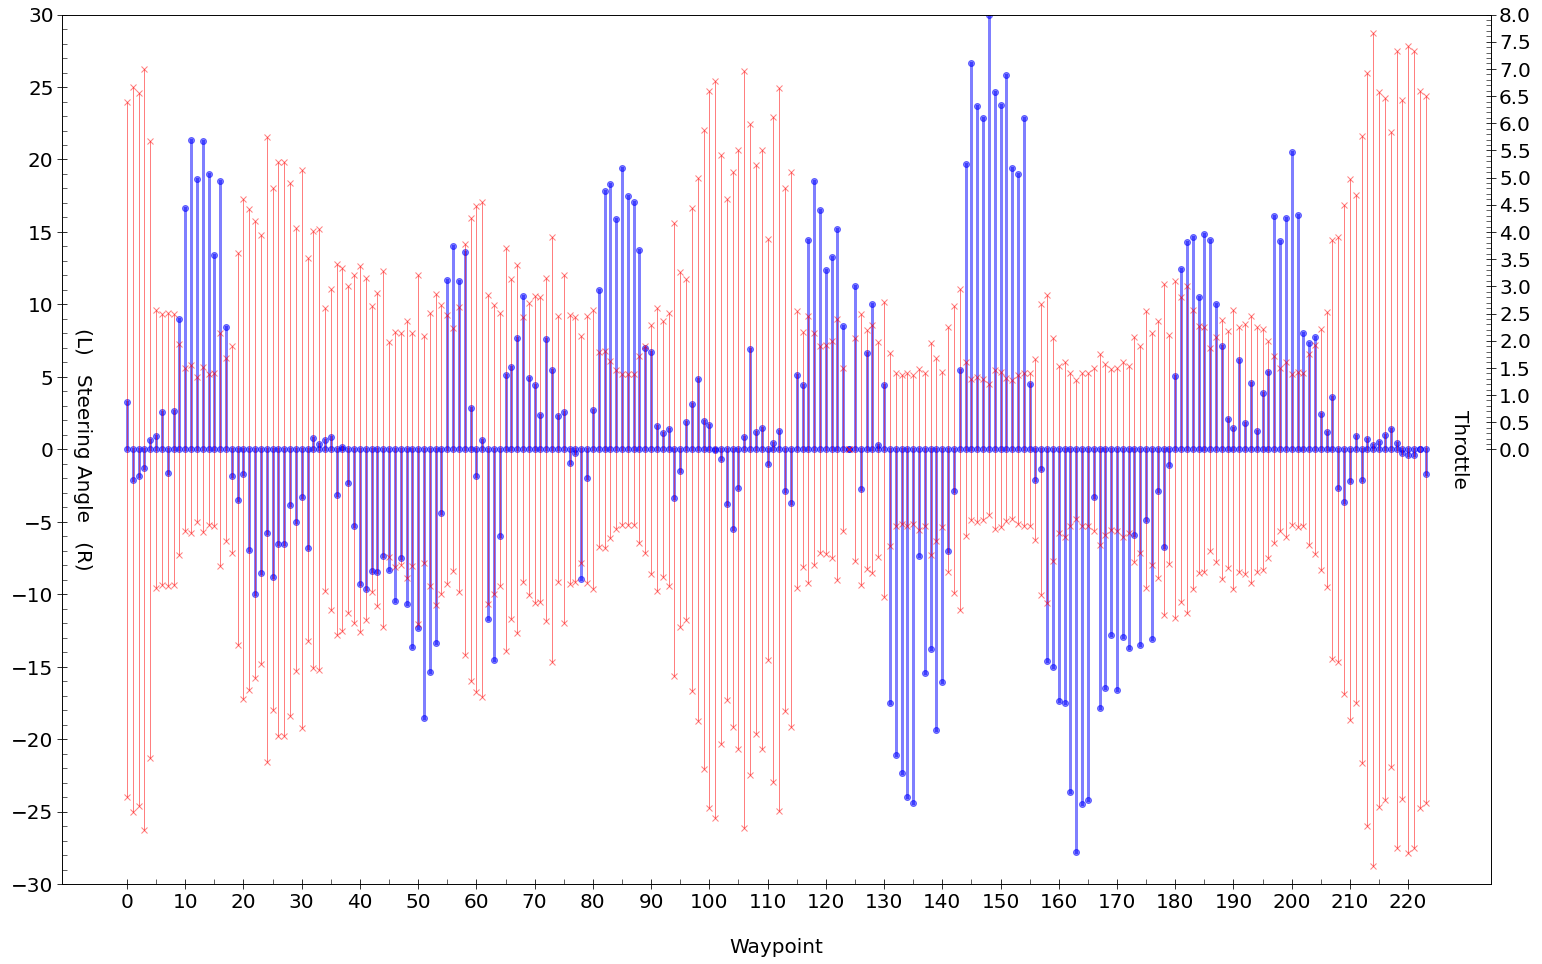

In [45]:
max_iteration = sim_df['iteration'].max()
max_episode = sim_df['episode'].max()
plot_speedsteering_per_waypoint_h(sim_df[sim_df['iteration']==max_iteration])
sim_df[sim_df['episode']==max_episode]
#plot_speedsteering_per_waypoint_h(sim_df[sim_df['episode']==21])
#sim_df[sim_df['episode']==21]

# Plot Avg Speed and Steering at Each Waypoint (Vertical) for the Most Recent Iteration
- Visualise the Avg Speed and Steering Angle at each waypoint (vertically), to identify inefficiencies in driving behaviour

In [46]:
def plot_speedsteering_per_waypoint_v(df):
    max_waypoint = df['closest_waypoint'].max()
    print ('max_waypoint: %d' % max_waypoint)
    
    max_steering = max(abs(df['steer'].min()), abs(df['steer'].max()))
    max_speed = df['throttle'].max()
    fig = plt.figure(figsize=(16, max_waypoint/10))
    
    plt.yticks(np.arange(0, max_waypoint+1, 5.0), fontsize=12)
    plt.ylabel('Waypoint\n', fontsize=20)
    plt.xticks(np.arange(math.floor(-max_steering), math.ceil(max_steering)+1, 5.0), fontsize=12)
    plt.xlabel('\n(L)   Steering Angle   (R)', fontsize=20)
    
    ax = plt.gca()  # gca stands for 'get current axis'
    ax.set_xlim(math.ceil(max_steering), math.floor(-max_steering))

    ax2 = ax.twiny()  # instantiate a second axes that shares the same x-axis
    ax2.set_xlabel('Throttle\n', fontsize=20)
    ax2.set_xlim(-max_speed, max_speed)
    ax2.set_xticks(np.arange(0, max_speed+0.5, 0.5))

    wp_steering = list(range(max_waypoint + 1))
    wp_steering_count = list(range(max_waypoint + 1))
    wp_speed = list(range(max_waypoint + 1))
    wp_speed_count = list(range(max_waypoint + 1))
    
    for wp in range(0, max_waypoint+1):
        wp_steering[wp] = 0
        wp_steering_count[wp] = 0
        wp_speed[wp] = 0
        wp_speed_count[wp] = 0

    for index, row in df.iterrows():
        closest_waypoint = row['closest_waypoint']
        steering_angle = row['steer']
        wp_steering[closest_waypoint] += steering_angle
        wp_steering_count[closest_waypoint] += 1
        speed = row['throttle']
        wp_speed[closest_waypoint] += (speed)
        wp_speed_count[closest_waypoint] += 1
        
    for wp in range(0, max_waypoint+1):
        if (wp_steering_count[wp]>0):
            avg_steering_angle = wp_steering[wp] / wp_steering_count[wp]
            x = [0, avg_steering_angle]
            y = [wp, wp]
            ax.plot(x, y, marker = 'o', color='blue', alpha=0.5, linewidth=3)
        else:
            ax.plot([0, 0], [wp, wp], marker = 'o', color='blue', alpha=0.5, linewidth=3)
        if (wp_speed_count[wp]>0):
            avg_speed = wp_speed[wp] / wp_speed_count[wp]
            x = [-avg_speed, avg_speed]
            y = [wp, wp]
            ax2.plot(x, y, marker = 'x', color='red', alpha=0.5, linewidth=1)
        else:
            ax2.plot([0, 0], [wp, wp], marker = 'x', color='red', alpha=0.5, linewidth=1)



max_waypoint: 223


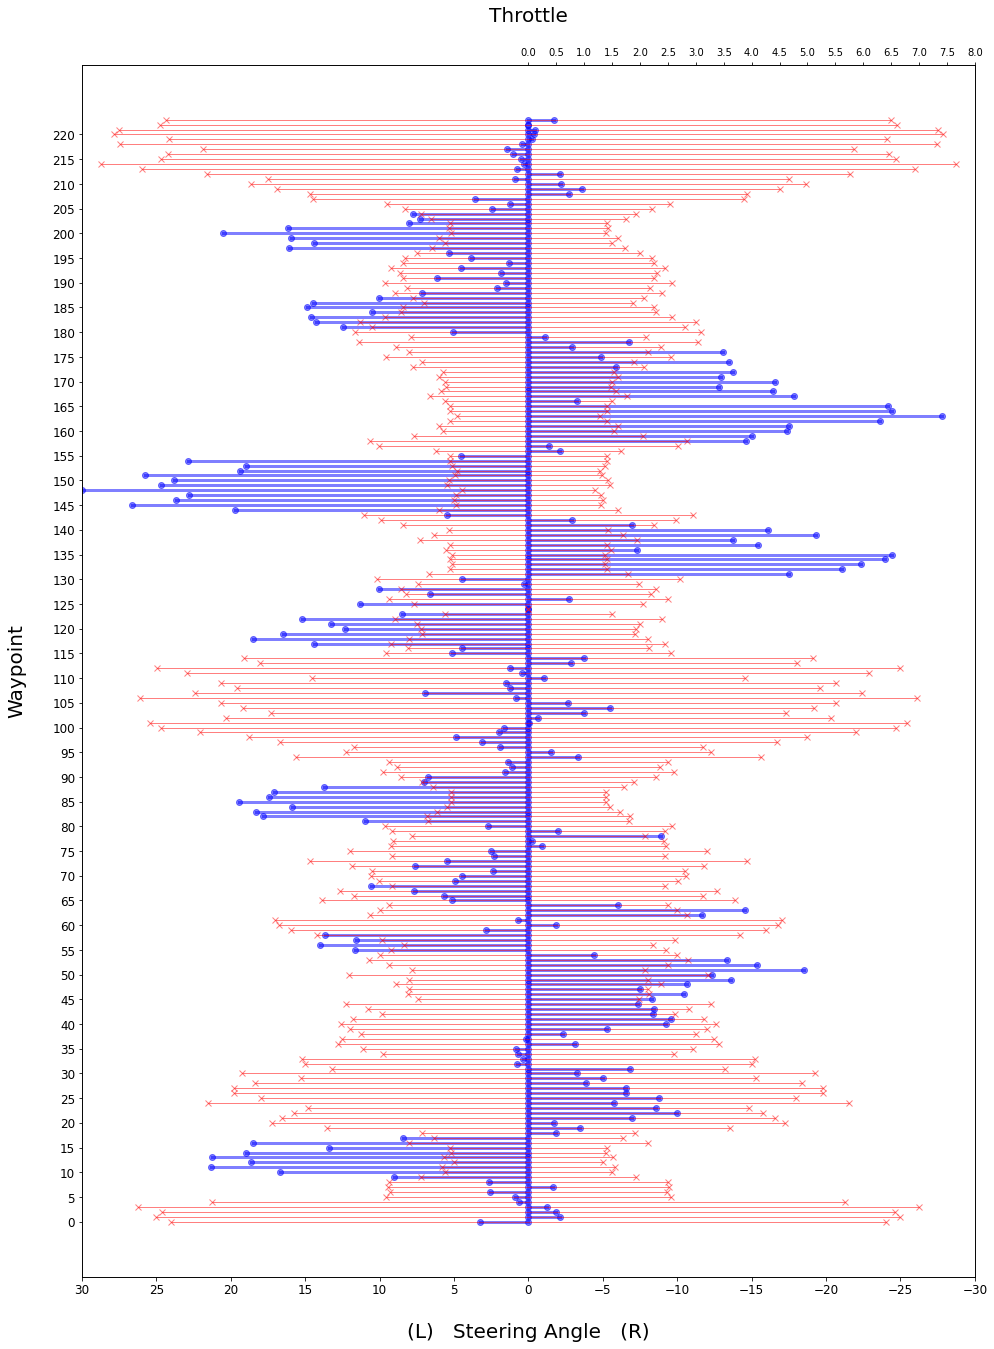

In [47]:
max_iteration = sim_df['iteration'].max()
plot_speedsteering_per_waypoint_v(sim_df[sim_df['iteration']==max_iteration])

# Plot Action / Reward Distribution Heatmap on Track

In [48]:
def plot_x_top_speed_y_top_angle_on_track(df, speed_index, angle_index, less_equal_angle, exact_angle, plot_reward, track_size=(500, 800), x_offset=0, y_offset=0):
    '''
    x_offset, y_offset is used to convert to the 0,0 coordinate system
    '''

    x_highest_speed = 0.0
    if speed_index != 0:
        action_speed_list = action_speed
        action_speed_list.sort()
        x_highest_speed = action_speed_list[-speed_index]
        print('Speed - X Highest: X=%d (%f)' % (speed_index, x_highest_speed))

    y_highest_angle = 0.0
    if angle_index != 0:
        action_steering_list = action_steering
        action_steering_list.sort()
        y_highest_angle = action_steering_list[-angle_index]
        print('Absolute Angle - Y Highest: Y=%d (%f)' % (angle_index, y_highest_angle))
    
    if less_equal_angle >= 0:
        print('Absolute Angle - Less Or Equal: %d' % (less_equal_angle))
        
    if exact_angle != 0:
        print('Absolute Angle - Exact: %d' % (exact_angle))        

    track = np.zeros(track_size) # lets magnify the track by *100
    for index, row in df.iterrows():
        x = int(row["x"]) + x_offset
        y = int(row["y"]) + y_offset
        reward = row["reward"]
        throttle = row["throttle"]
        steer = row["steer"]
        
        if ((throttle == x_highest_speed) or (speed_index == 0)) and ((abs(steer) == y_highest_angle) or (angle_index == 0)) and ((abs(steer) <= less_equal_angle) or (less_equal_angle < 0)) and ((abs(steer) == exact_angle) or (exact_angle == 0)):
            if (plot_reward == True):
                track[y,x] = reward
            else:
                track[y,x] = 1
        
    fig = plt.figure(1, figsize=(plot_x_max/50, plot_y_max/50))
    ax = fig.add_subplot(111)
    print_border(ax, center_line, inner_border, outer_border, racing_track)
    return track

In [49]:
def plot_x_top_speed_y_top_angle_on_track_for_iteration(curr_iteration, speed_index, angle_index, less_equal_angle, exact_angle, plot_reward):
    max_iteration = sim_df['iteration'].max()
    if (curr_iteration == 0):
        curr_iteration = max_iteration
    df_slice = sim_df[sim_df['iteration']<=curr_iteration]
    df_slice = df_slice[df_slice['iteration']>(curr_iteration-5)]

    track = plot_x_top_speed_y_top_angle_on_track(df_slice, speed_index, angle_index, less_equal_angle, exact_angle, plot_reward, track_size=(plot_y_max, plot_x_max), x_offset=x_offset, y_offset=y_offset)
    title_prefix = ''
    if (plot_reward == True):
        title_prefix = 'Reward '
    plt.title("%sDistribution for X Highest Speed & Y Highest Angle\nAngle Less or Eq to Z & Eq to W\nX: %d / Y: %d / Z: %d / W: %d" % (title_prefix, speed_index, angle_index, less_equal_angle, exact_angle))
    im = plt.imshow(track, cmap='hot', interpolation='bilinear', origin="lower") 

# Plot Reward Distribution Heatmap on Track for the Most Recent Iteration
- Verify that we're not rewarding for bad driving behaviour
- Overlay a heatmap of rewards on the track to identify areas of improvement for the Reward Function; this could also highlight sections where the car is over- and under-steering, or where the car is not driving smoothly

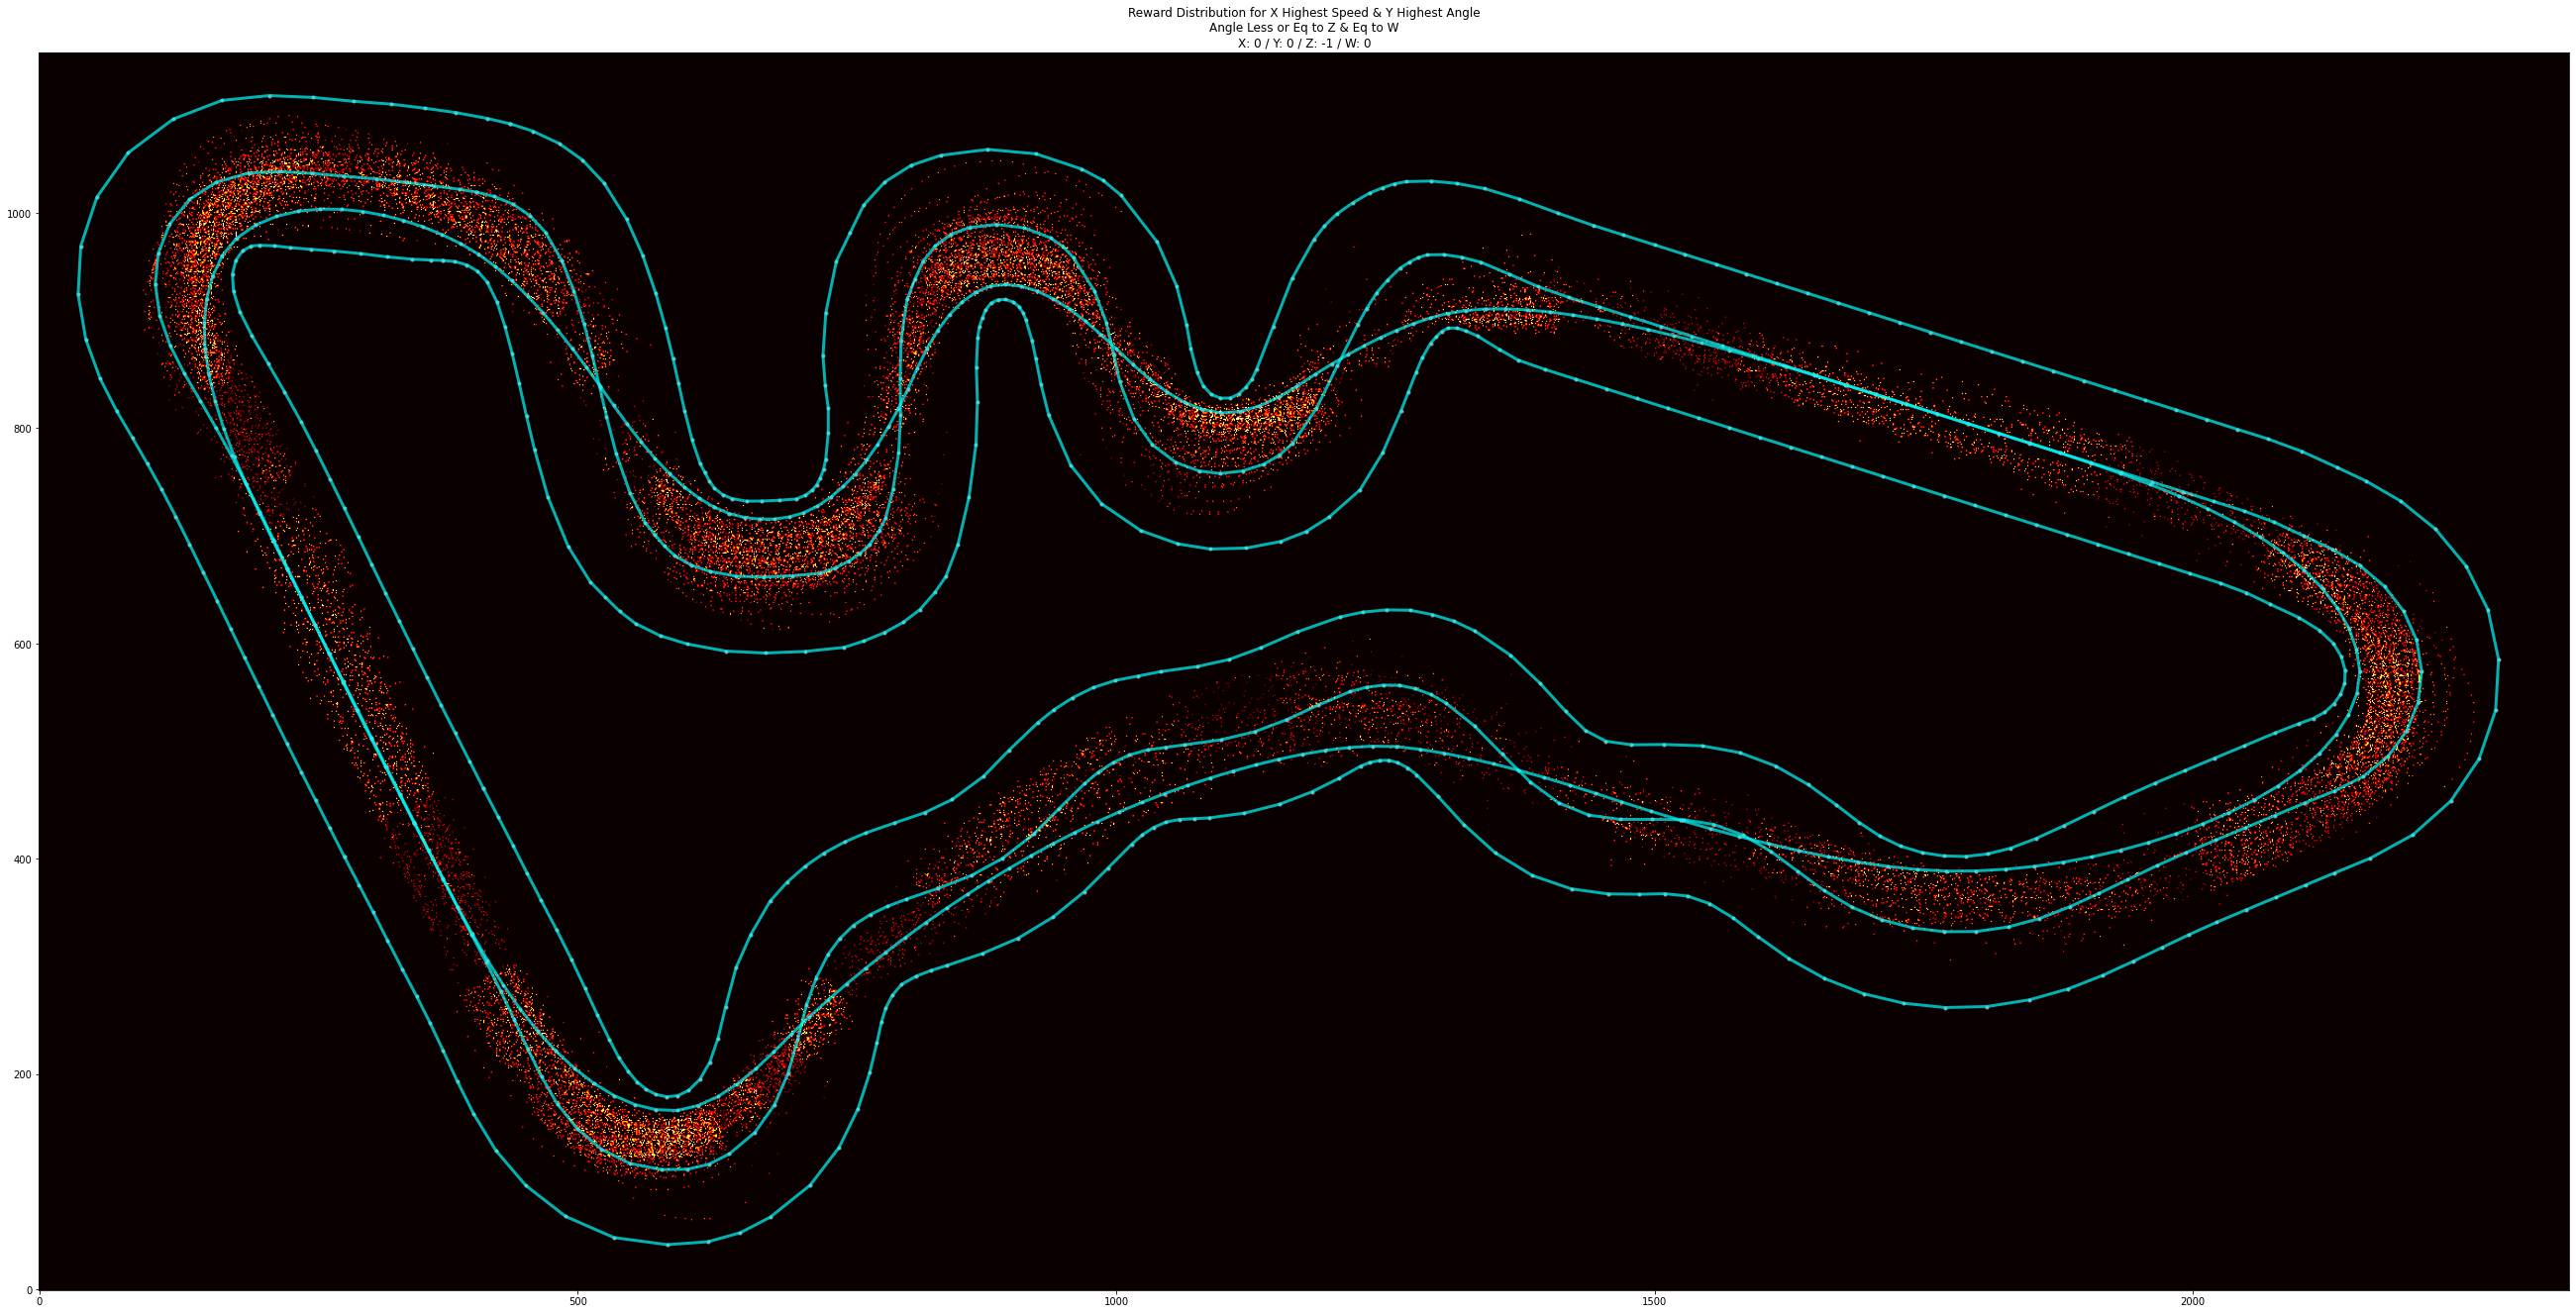

In [50]:
max_iteration = sim_df['iteration'].max()
plot_x_top_speed_y_top_angle_on_track_for_iteration(max_iteration, 0, 0, -1, 0, True)

# Plot Highest-Speed Action Distribution Heatmap on Track for the Most Recent Iteration
- Verify that the model uses the highest speed at appropriate sections of the track (eg., on straights)

Speed - X Highest: X=1 (8.000000)


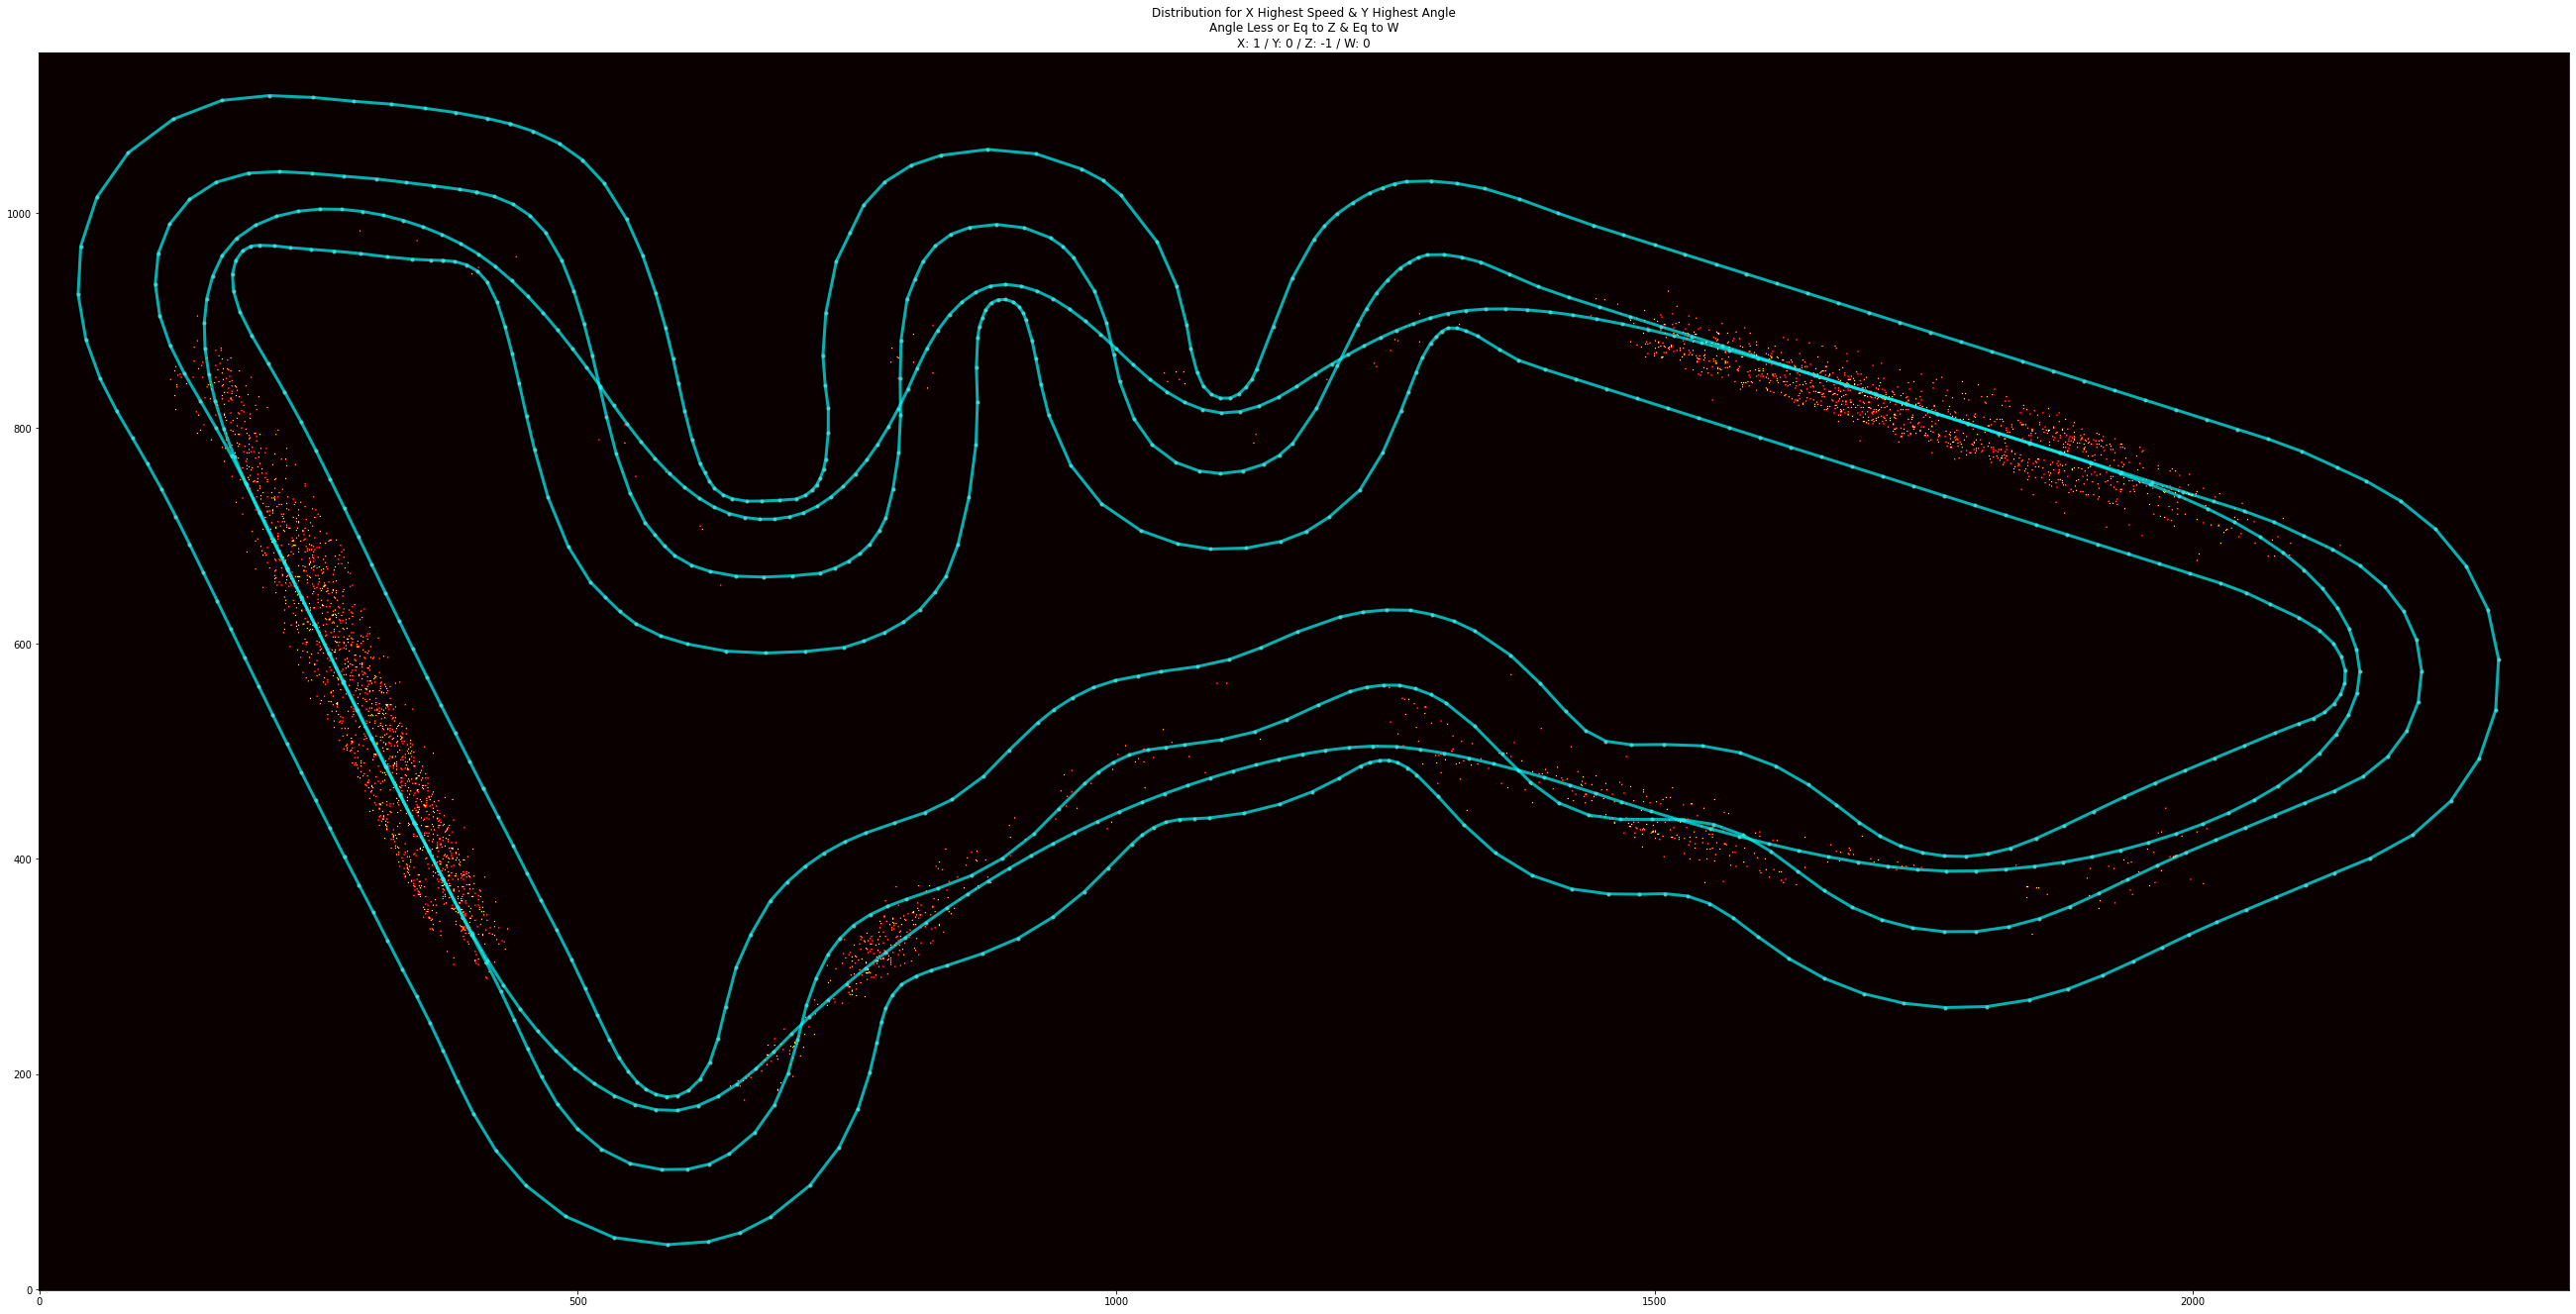

In [51]:
max_iteration = sim_df['iteration'].max()
plot_x_top_speed_y_top_angle_on_track_for_iteration(max_iteration, 1, 0, -1, 0, False)

# Plot 0-Degree Steering Distribution Heatmap on Track for the Most Recent Iteration
- Analyse the various sections of the track where the model is driving straight, to identify sections where we could potentially tweak the actions / rewards

Absolute Angle - Less Or Equal: 0


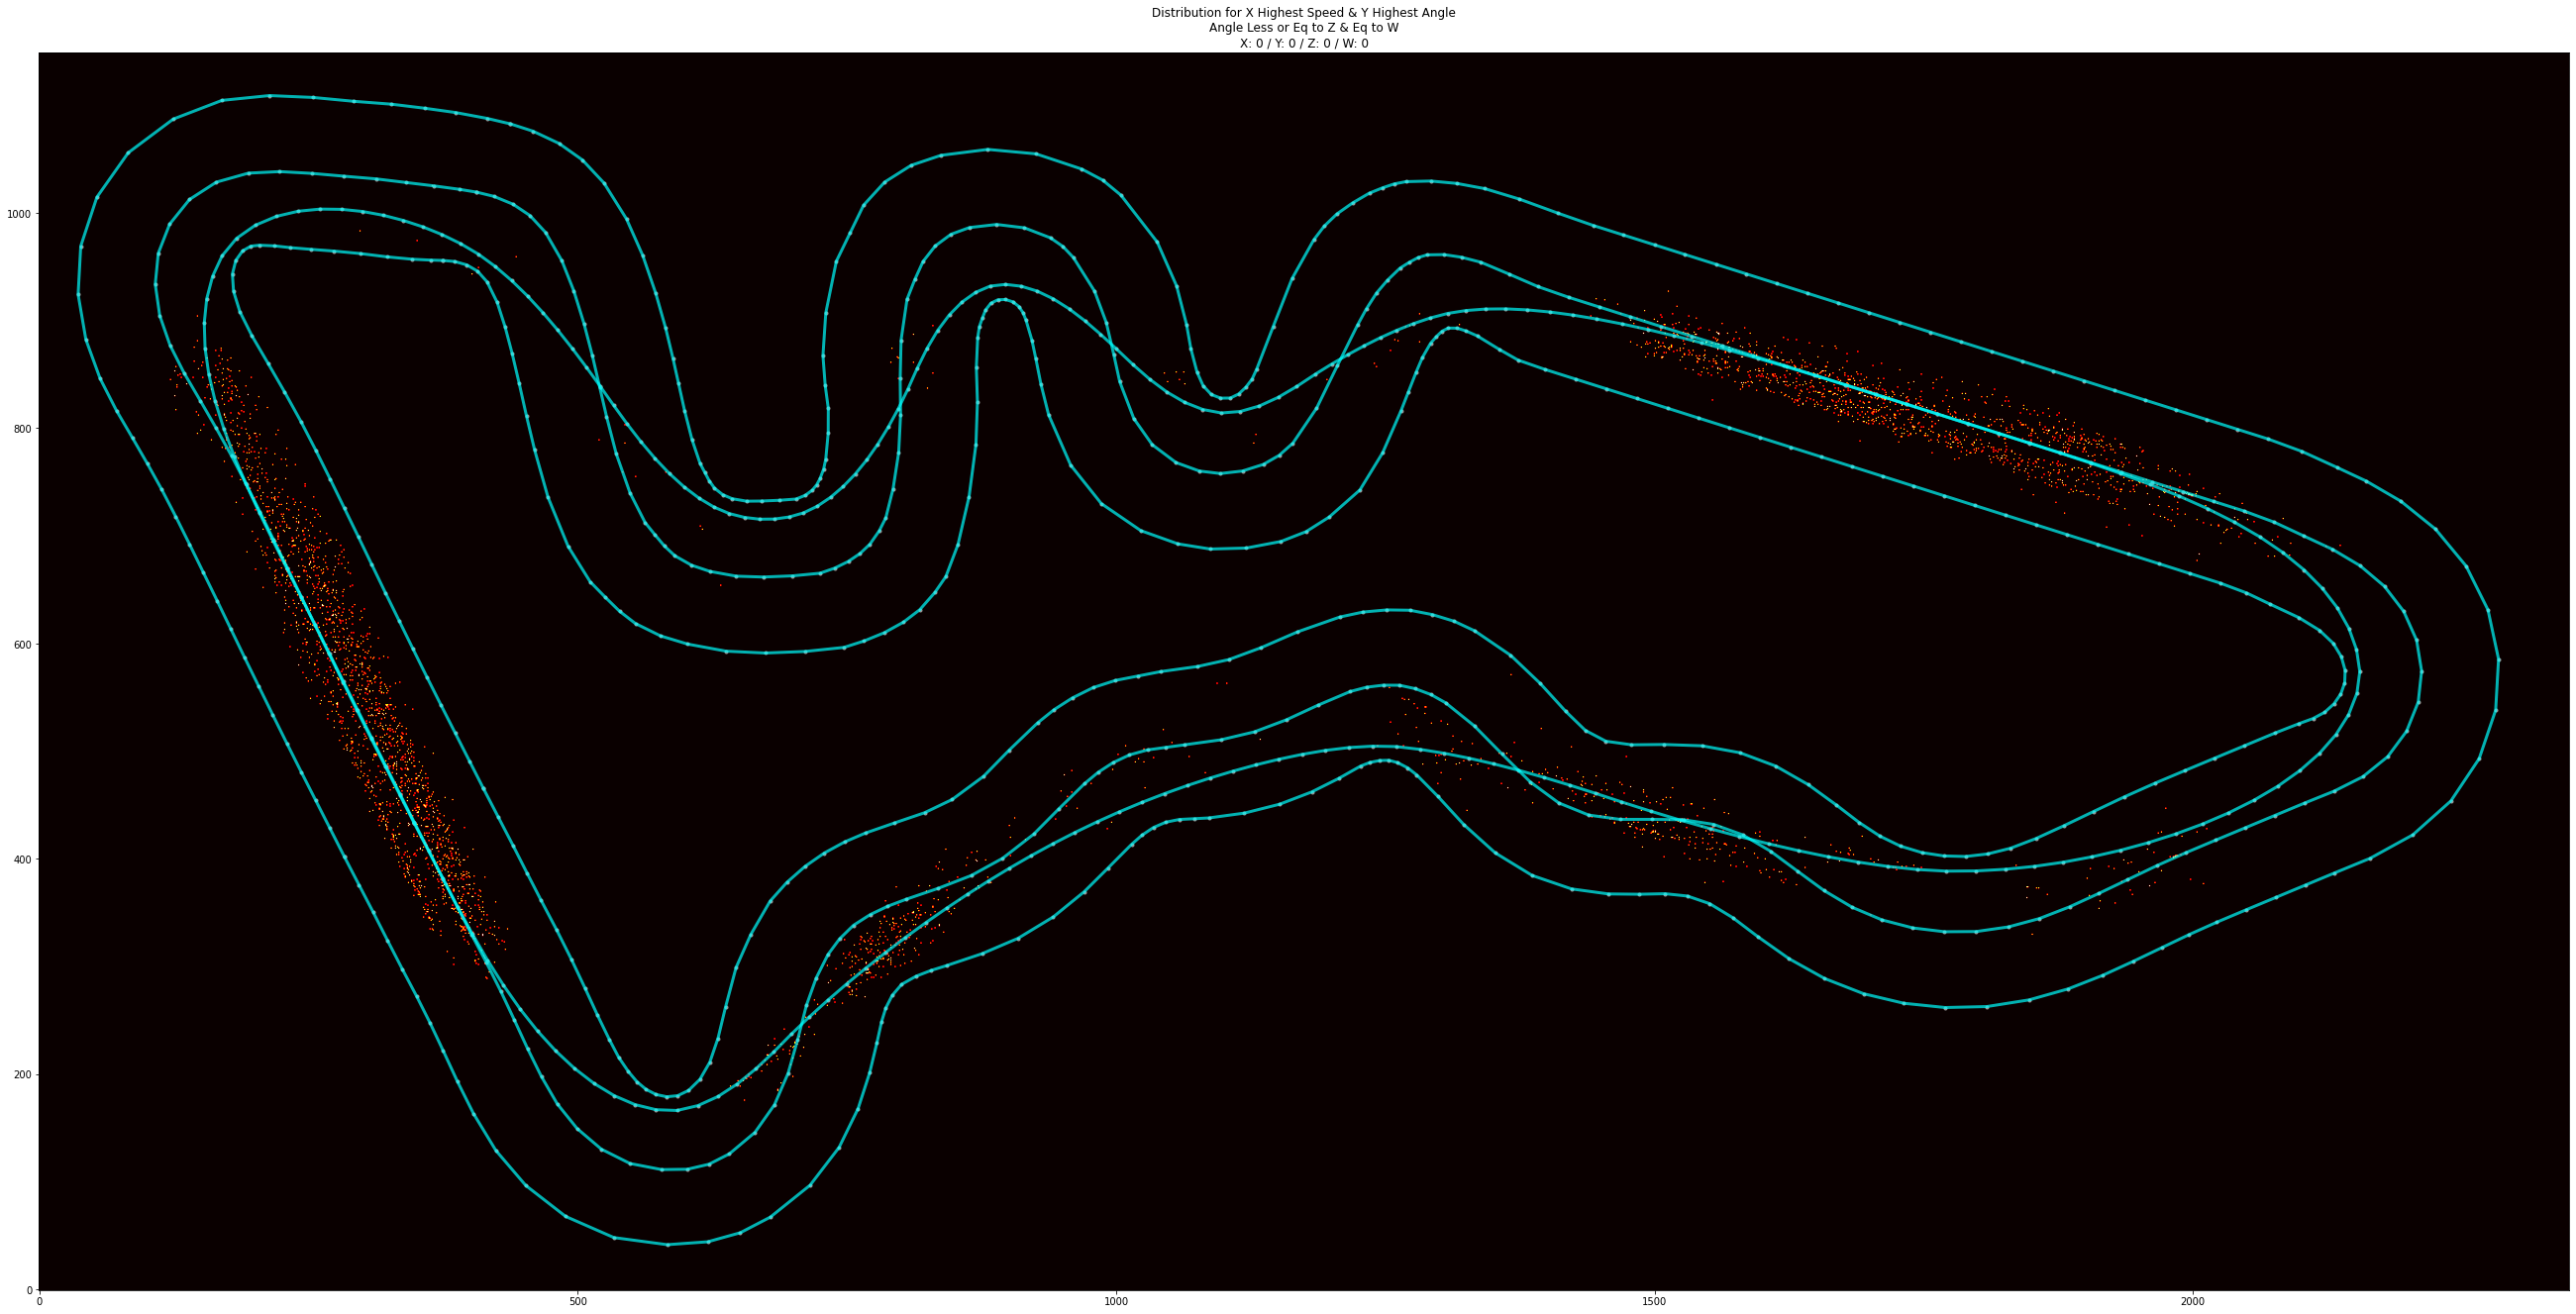

In [52]:
max_iteration = sim_df['iteration'].max()
plot_x_top_speed_y_top_angle_on_track_for_iteration(max_iteration, 0, 0, 0, 0, False)

# Plot Widest Steering-Angle Distribution Heatmap on Track for the Most Recent Iteration
- Analyse the various sections of the track where the model is steering heavily, to identify sections where we could potentially tweak the actions / rewards
- Assumes there are symmetrical -ve and +ve steering angles (otherwise this would plot only the side that has the biggest absolute steering angle value)

Absolute Angle - Y Highest: Y=1 (30.000000)


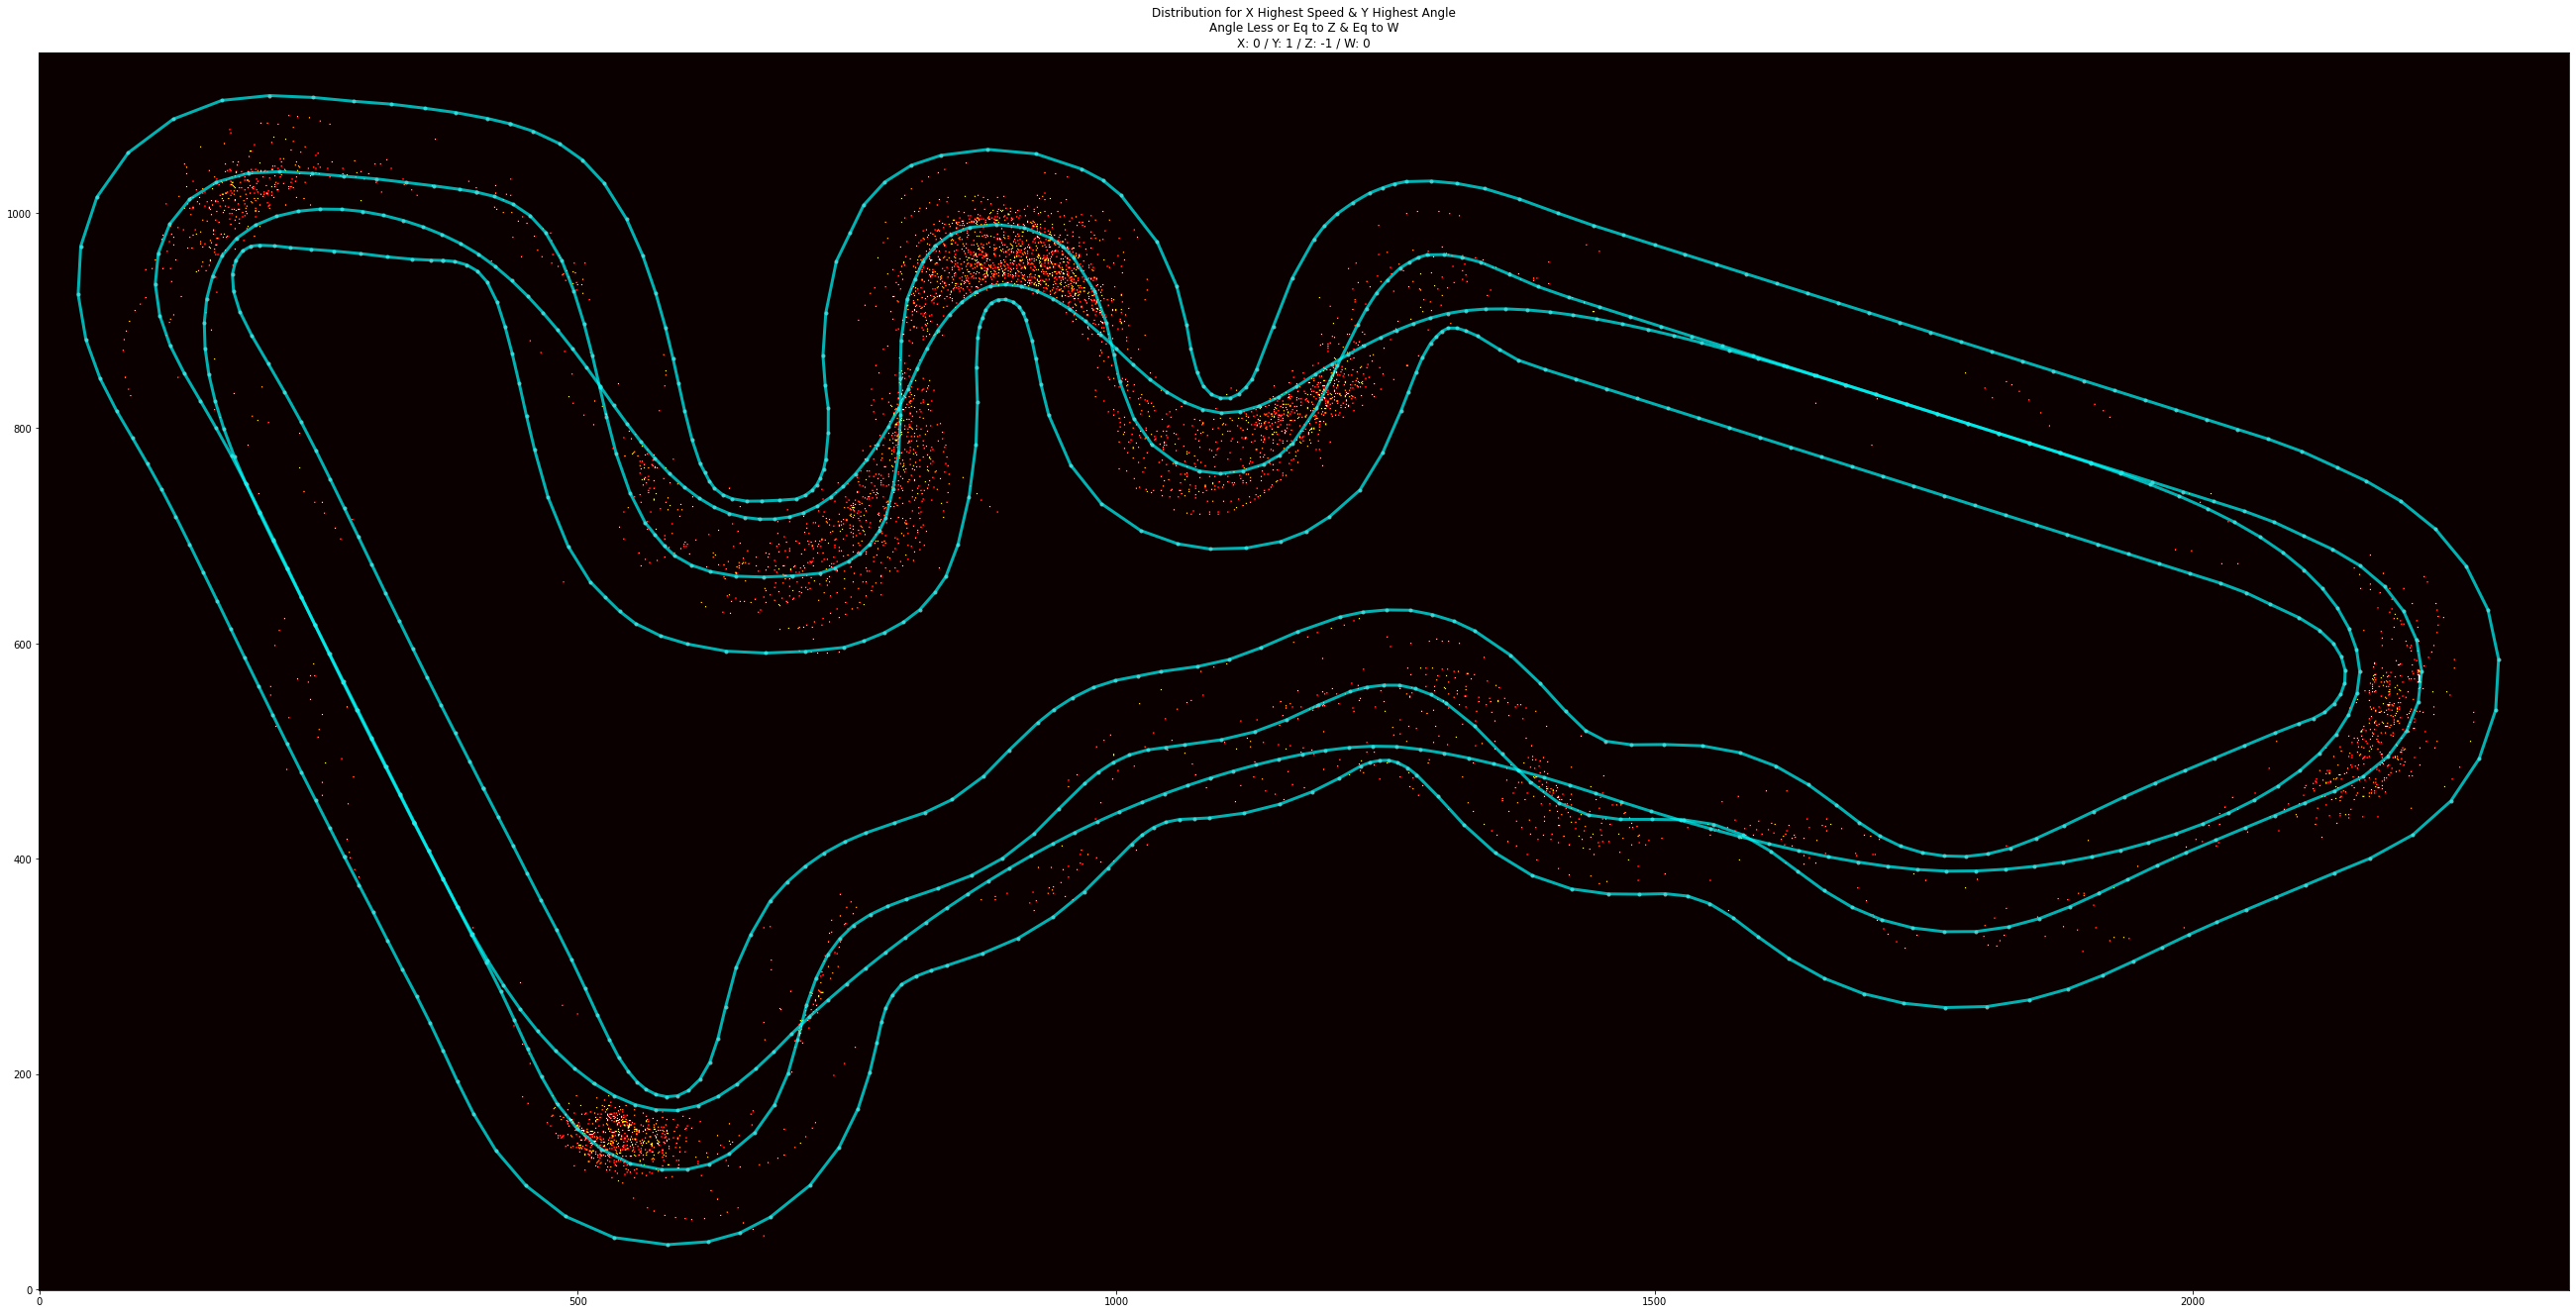

In [53]:
max_iteration = sim_df['iteration'].max()
plot_x_top_speed_y_top_angle_on_track_for_iteration(max_iteration, 0, 1, -1, 0, False)

# Plot Path Taken for the Fastest Completed Lap

In [54]:
def plot_top_laps(sorted_idx, n_laps=5, x_offset=0, y_offset=0, plot_yaw=False, plot_steer=False, plot_labels=False):
    fig = plt.figure(n_laps, figsize=(plot_x_max/50, plot_y_max/50*n_laps))
    for i in range(n_laps):
        ax = fig.add_subplot(n_laps,1,i+1)
        
        line = LineString(center_line)
        plot_coords(ax, line)
        plot_line(ax, line)
        
        line = LineString(inner_border)
        plot_coords(ax, line)
        plot_line(ax, line)

        line = LineString(outer_border)
        plot_coords(ax, line)
        plot_line(ax, line)

        line = LineString(racing_track)
        plot_coords(ax, line)
        plot_line(ax, line)

        idx = sorted_idx[i]
        episode_data = sim_df[sim_df['episode']==idx]
        episode = sim_df_episodes[sim_df_episodes['episode']==idx]

        plt.title('Episode: %s (Iteration: %d, Episode-in-Iteration: %d), Steps: %d, Progress: %.2f, Rewards: %.2f, Elapsed Time: %.2fs, Status: %s' % (idx, episode['iteration'], episode['episode_in_iteration'], episode['steps'], episode['progress'], episode['episode_total_rewards'], episode['elapsed_time'], episode['status'].values[0]))
        for index, row in episode_data.iterrows():
            x1 = row['x']
            y1 = row['y']
            car_x2, car_y2 = x1 - 0.02, y1
            plt.plot([x1+x_offset, car_x2+x_offset], [y1+y_offset, car_y2+y_offset], 'b.')
            
            if (plot_yaw):
                dx = 5*row['throttle']*math.cos(row['yaw']*math.pi/180)
                dy = 5*row['throttle']*math.sin(row['yaw']*math.pi/180)
                plt.arrow(x1+x_offset, y1+y_offset, dx, dy, linewidth=1, head_width=8, head_length=5, fc='b', ec='b', zorder=99)
    
            if (plot_steer):
                dx = 5*row['throttle']*math.cos((row['yaw']+row['steer'])*math.pi/180)
                dy = 5*row['throttle']*math.sin((row['yaw']+row['steer'])*math.pi/180)
                if row['steer'] < 0:
                    steer_color = 'r'
                elif row['steer'] > 0:
                    steer_color = 'lime'
                else:
                    steer_color = 'y'
                plt.arrow(x1+x_offset, y1+y_offset, dx, dy, linewidth=1, head_width=8, head_length=5, fc=steer_color, ec=steer_color, zorder=99)

            if (plot_labels):
                label_txt = '  STP: %s, WP: %s, HD:%0.2f, STR:%s, THR:%s' % (row['steps'], row['closest_waypoint'], row['yaw'], row['steer'], row['throttle'])
                plt.text(x1+x_offset, y1+y_offset, label_txt)
                print(label_txt)
    return fig



In [55]:
sim_df_episodes_fastest_full_lap = sim_df_episodes[sim_df_episodes['progress']>=100.0].sort_values('elapsed_time', ascending=True).head(1)
sim_df_episodes_fastest_full_lap

iteration  episode_in_iteration  episode  steps  progress  \
643168        144                    35     5795    339     100.0   

              status  episode_total_rewards  elapsed_time    start_time  \
643168  lap_complete               661.8606     22.922493  1.606685e+09   

            end_time  
643168  1.606685e+09

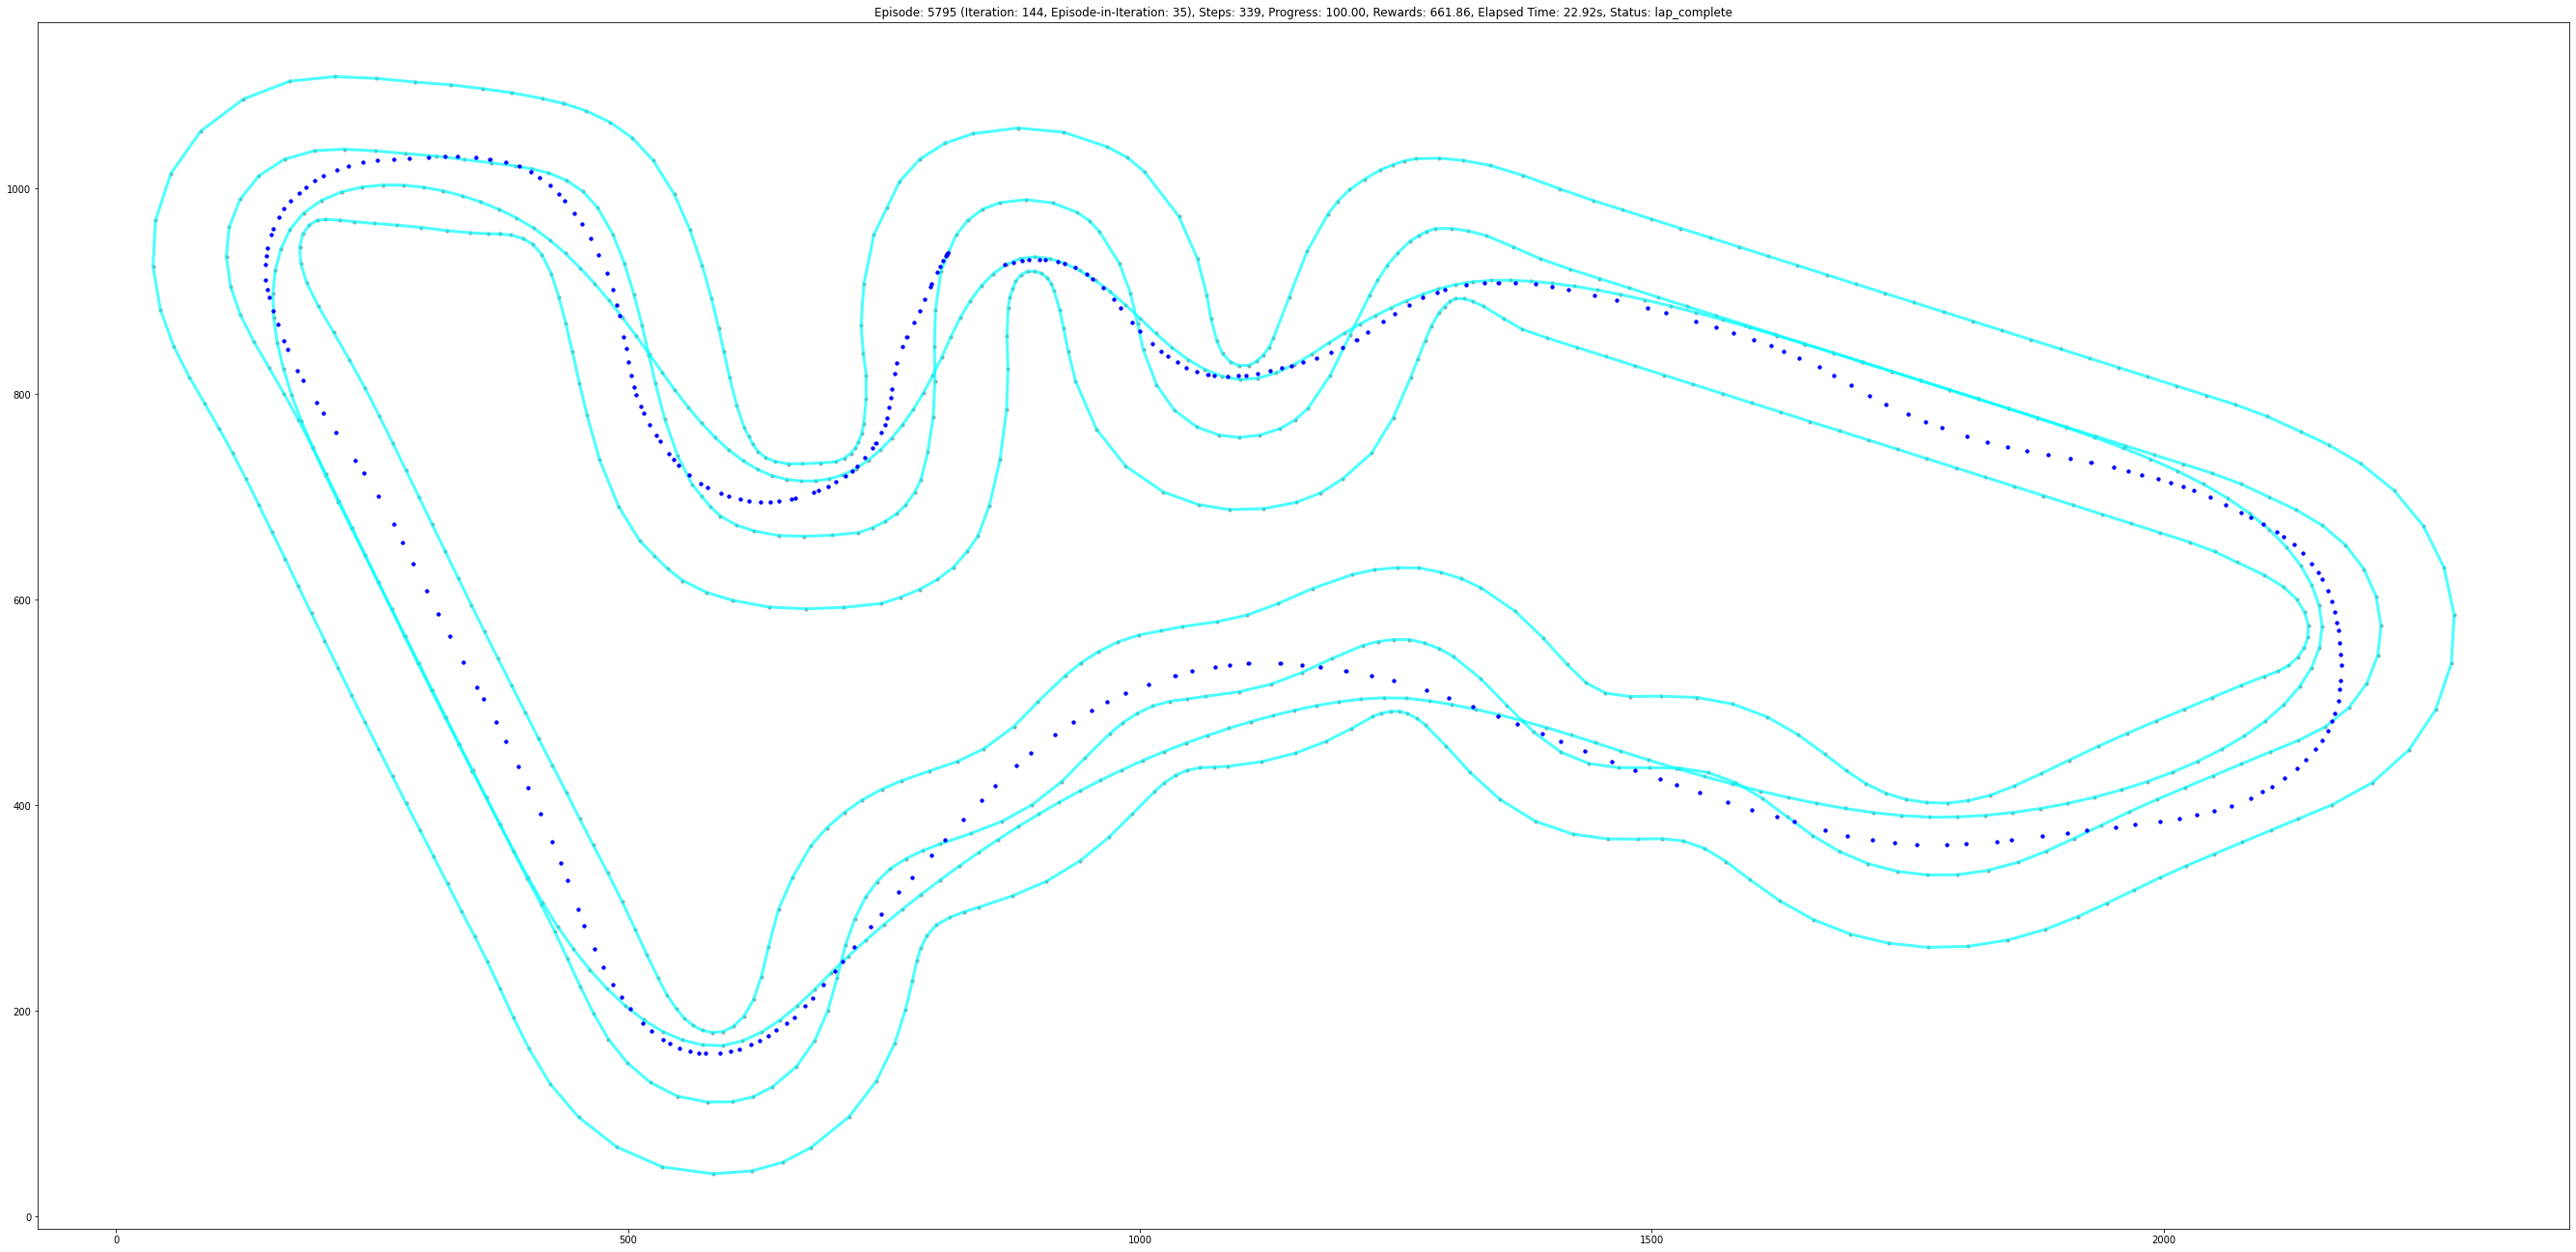

In [56]:
if sim_df_episodes_fastest_full_lap['episode'].count() > 0:
    fig = plot_top_laps(sim_df_episodes_fastest_full_lap['episode'].values, len(sim_df_episodes_fastest_full_lap), x_offset, y_offset)

# Plot the Vectors of the Steps Taken Throughout the Fastest Lap
For any given step:
- Blue arrow indicates the HEADING of the car
- Green arrow indicates that the car is steering LEFT
- Yellow arrow indicates that the car is steering STRAIGHT
- Red arrow indicate that the car is steering RIGHT
- The length of each arrow indicates the relative speed of the car

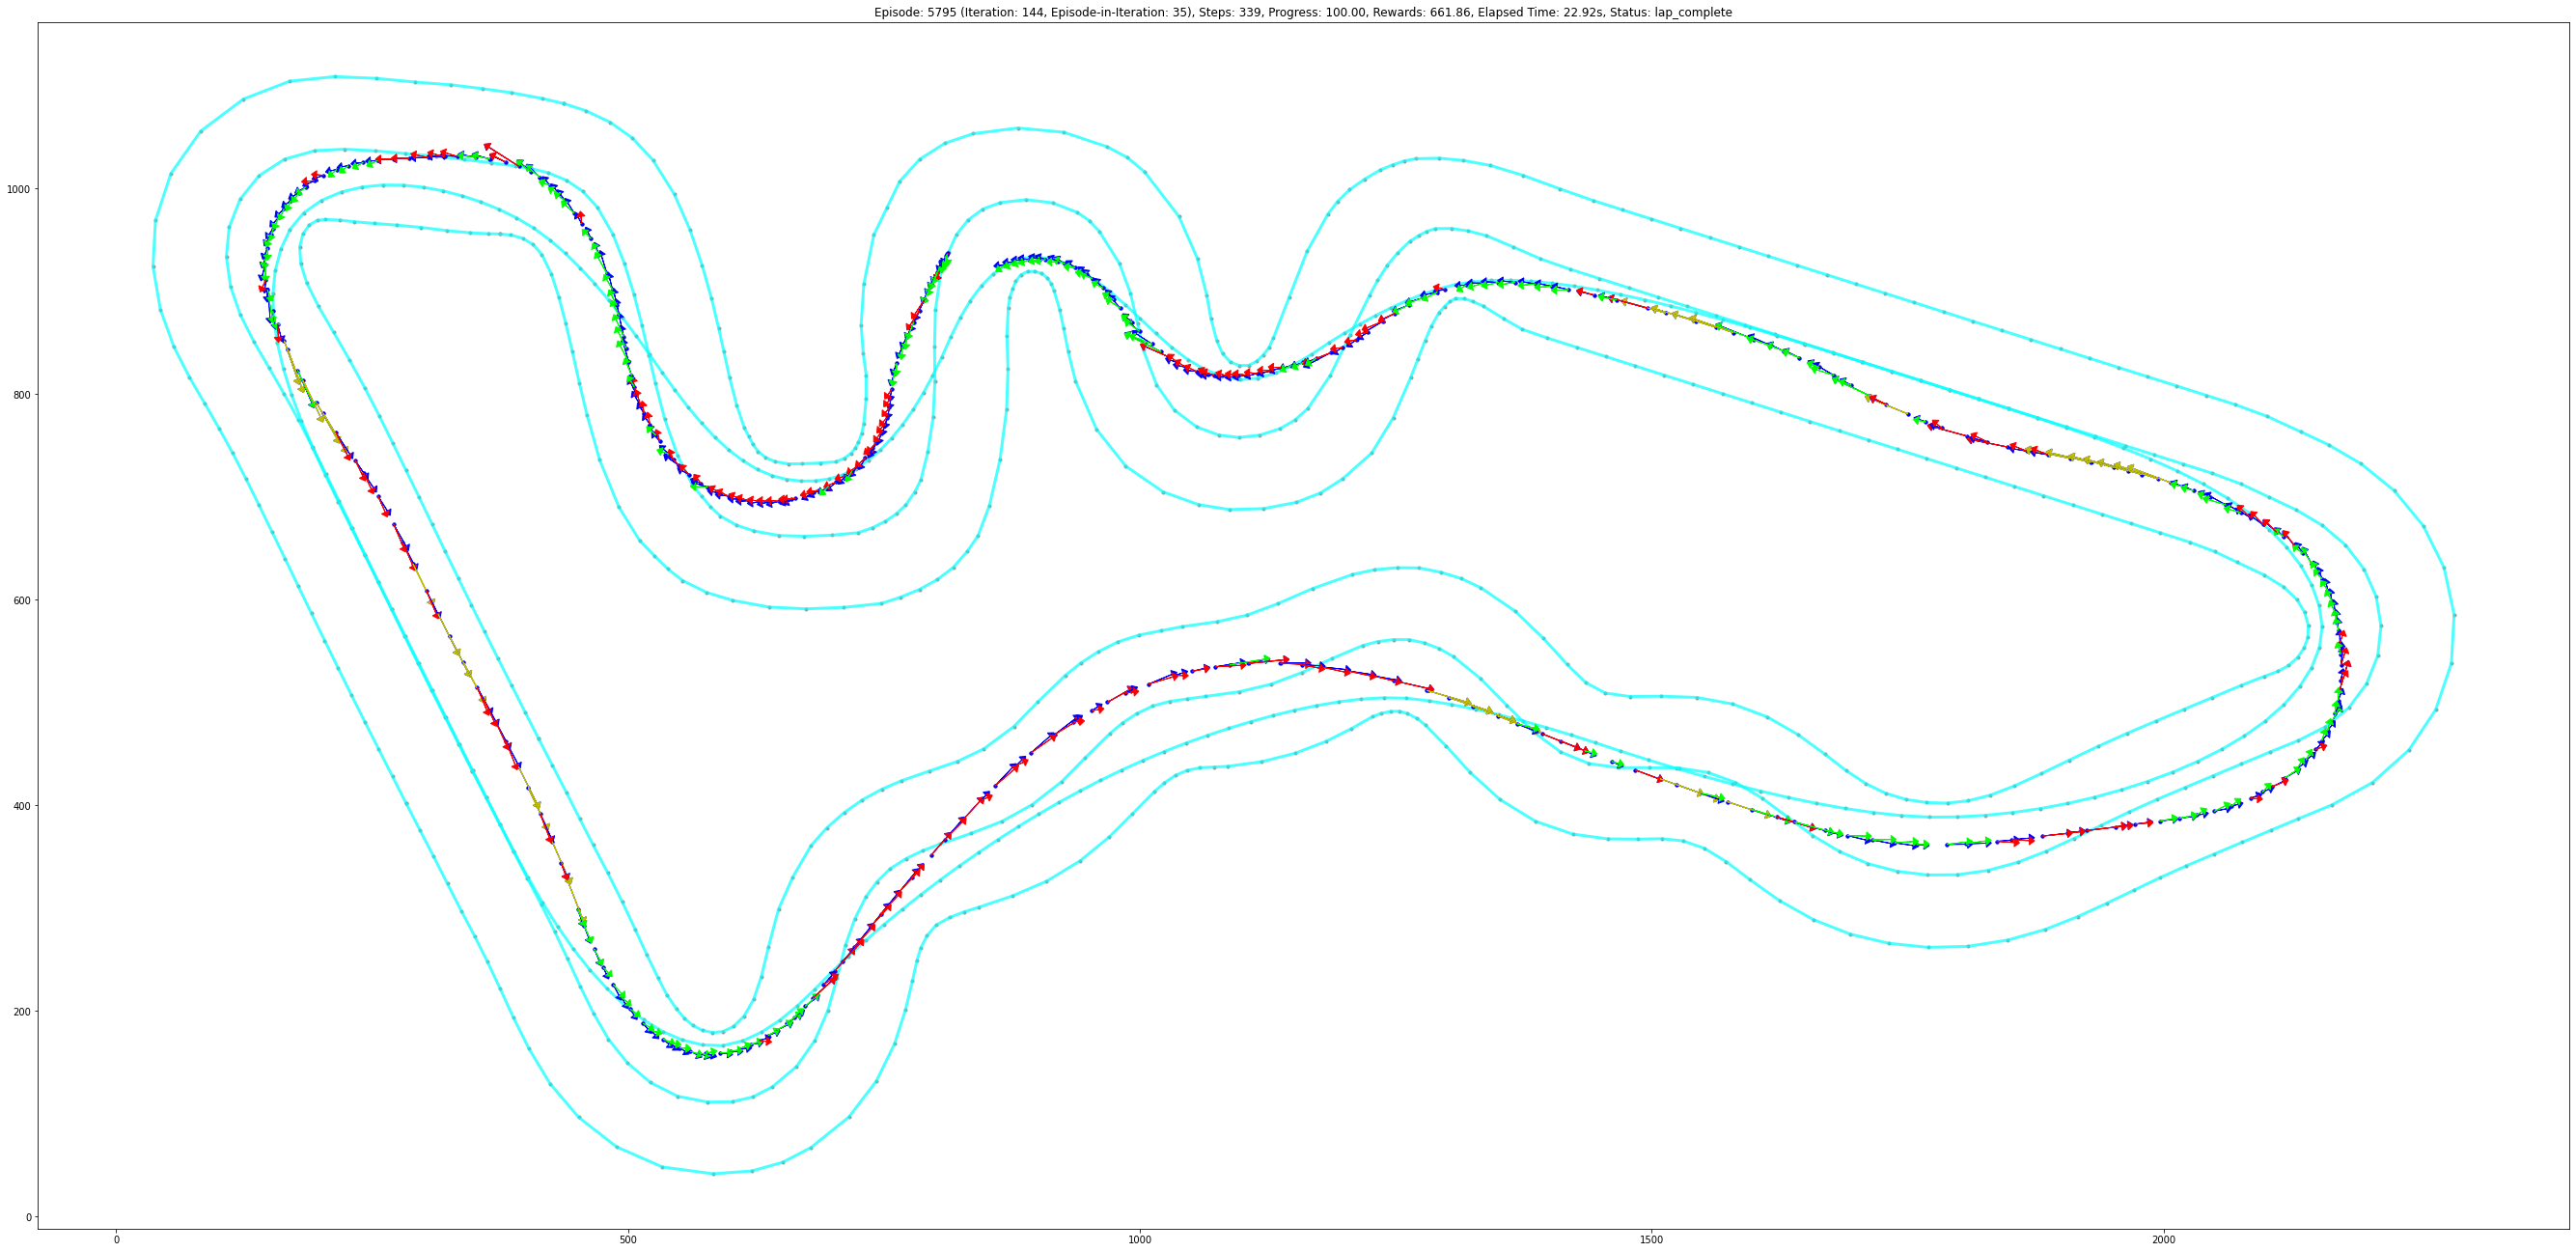

In [57]:
if sim_df_episodes_fastest_full_lap['episode'].count() > 0:
    fig = plot_top_laps(sim_df_episodes_fastest_full_lap['episode'].values, len(sim_df_episodes_fastest_full_lap), x_offset, y_offset, True, True)

In [58]:
fpath = "./racelines/Austin-1500-4-2020-11-26-203913.npy"

racing_track = np.load(fpath)

# Convert np array to list and remove last point because it is the same point as the first one
#racing_track = racing_track.tolist()[:]

In [59]:
def get_track_waypoints(track_name):
    return np.load("tracks/%s.npy" % track_name)
    
waypoints = get_track_waypoints(WORLD_NAME)
waypoints.shape

(224, 6)

In [60]:
def plot_points(ax, points):
    ax.scatter(points[:-1,0], points[:-1,1], s=1)
    for i,p in enumerate(points):
        if i % 5 == 0:
            ax.annotate(i, (p[0], p[1]))
        #else:
            #ax.annotate('*', (p[0], p[1]), color=color)

def plot_line(ax, ob, color):
    ob = LineString(ob)                                                
    x, y = ob.xy                                                                
    ax.plot(x, y, color=color, alpha=0.5, linewidth=3, solid_capstyle='round', zorder=2)


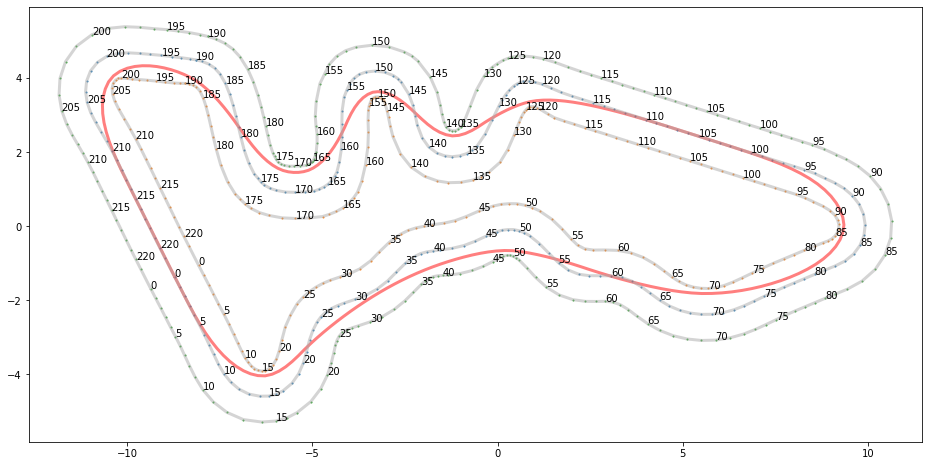

In [61]:
# Plot the results
fig, ax = plt.subplots(figsize=(16,8))


plot_line(ax, racing_track, 'red' )
plot_line(ax, waypoints[:,0:2], '#aaaaaa')
plot_line(ax, waypoints[:,2:4], '#aaaaaa')
plot_line(ax, waypoints[:,4:6], '#aaaaaa')

plot_points(ax, waypoints[:-1,0:2])
plot_points(ax, waypoints[:-1,2:4])
plot_points(ax, waypoints[:-1,4:6])
ax.axis('equal')
plt.show()